In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17            

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-07 19:04:46,903] A new study created in memory with name: no-name-3d52d9a1-bd67-44f2-a265-d6e6fdd0d3d9
[I 2025-06-07 19:08:54,272] Trial 0 finished with value: 6.256900787353516 and parameters: {'lr': 0.07214986823244242, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.44054549062574433}. Best is trial 0 with value: 6.256900787353516.


Cross Validation Accuracies:
[6.043418884277344, 5.113342761993408, 7.292977809906006, 5.278020858764648, 7.556743621826172]
Mean Cross Validation Accuracy:
6.256900787353516
Standard Deviation of Cross Validation Accuracy:
1.0074276535704012


[I 2025-06-07 19:14:32,356] Trial 1 finished with value: 0.21507480442523957 and parameters: {'lr': 0.0014686370771535074, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2301045717293896}. Best is trial 1 with value: 0.21507480442523957.


Cross Validation Accuracies:
[0.37871915102005005, 0.21387669444084167, 0.13970570266246796, 0.131112739443779, 0.21195973455905914]
Mean Cross Validation Accuracy:
0.21507480442523957
Standard Deviation of Cross Validation Accuracy:
0.08890527673510318


[I 2025-06-07 19:18:47,521] Trial 2 finished with value: 0.09122072160243988 and parameters: {'lr': 0.007824117797849353, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2454170008234042}. Best is trial 2 with value: 0.09122072160243988.


Cross Validation Accuracies:
[0.115384042263031, 0.09031475335359573, 0.07498762756586075, 0.10636571794748306, 0.06905146688222885]
Mean Cross Validation Accuracy:
0.09122072160243988
Standard Deviation of Cross Validation Accuracy:
0.017714665985876534


[I 2025-06-07 19:24:01,467] Trial 3 finished with value: 0.22618072032928466 and parameters: {'lr': 0.01265549162317849, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.42938881977404464}. Best is trial 2 with value: 0.09122072160243988.


Cross Validation Accuracies:
[0.2601050138473511, 0.14730288088321686, 0.29201391339302063, 0.2797049283981323, 0.15177686512470245]
Mean Cross Validation Accuracy:
0.22618072032928466
Standard Deviation of Cross Validation Accuracy:
0.06341506930383099


[I 2025-06-07 19:29:11,013] Trial 4 finished with value: 0.07431260272860526 and parameters: {'lr': 0.003057989556807071, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.24382484784564096}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.08816100656986237, 0.07428029179573059, 0.07064718008041382, 0.0803648829460144, 0.05810965225100517]
Mean Cross Validation Accuracy:
0.07431260272860526
Standard Deviation of Cross Validation Accuracy:
0.010043708041818077


[I 2025-06-07 19:33:38,643] Trial 5 finished with value: 1.0657151222229004 and parameters: {'lr': 0.4124161472529936, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1618109787429393}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[1.3415849208831787, 1.2149219512939453, 0.9922312498092651, 0.778874397277832, 1.0009630918502808]
Mean Cross Validation Accuracy:
1.0657151222229004
Standard Deviation of Cross Validation Accuracy:
0.1950574941311361


[I 2025-06-07 19:38:08,743] Trial 6 finished with value: 0.12065180093050003 and parameters: {'lr': 0.004692411563413205, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2918178286018678}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.12473076581954956, 0.13110537827014923, 0.11796976625919342, 0.15784689784049988, 0.07160619646310806]
Mean Cross Validation Accuracy:
0.12065180093050003
Standard Deviation of Cross Validation Accuracy:
0.028007338664915508


[I 2025-06-07 19:42:49,284] Trial 7 finished with value: 1.014807677268982 and parameters: {'lr': 0.013922566046651267, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.44806008530203245}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.8779828548431396, 0.9038547277450562, 1.0799660682678223, 1.0115606784820557, 1.200674057006836]
Mean Cross Validation Accuracy:
1.014807677268982
Standard Deviation of Cross Validation Accuracy:
0.11818126676885664


[I 2025-06-07 19:48:08,389] Trial 8 finished with value: 8.657127094268798 and parameters: {'lr': 0.8623501776884873, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2909967586562904}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[8.742223739624023, 8.057876586914062, 4.30825662612915, 8.852049827575684, 13.325228691101074]
Mean Cross Validation Accuracy:
8.657127094268798
Standard Deviation of Cross Validation Accuracy:
2.8673396850942043


[I 2025-06-07 19:54:01,761] Trial 9 finished with value: 0.4787074029445648 and parameters: {'lr': 0.18413192193171726, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.42215499180898275}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.6502199172973633, 0.43146684765815735, 0.338302344083786, 0.5830122232437134, 0.3905356824398041]
Mean Cross Validation Accuracy:
0.4787074029445648
Standard Deviation of Cross Validation Accuracy:
0.11833472950194554


[I 2025-06-07 20:00:03,934] Trial 10 finished with value: 0.6117205739021301 and parameters: {'lr': 0.00102323083431549, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11378172770649989}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.5628726482391357, 0.6179651618003845, 0.6145361661911011, 0.6335655450820923, 0.629663348197937]
Mean Cross Validation Accuracy:
0.6117205739021301
Standard Deviation of Cross Validation Accuracy:
0.025425137934012507


[I 2025-06-07 20:06:15,065] Trial 11 finished with value: 0.08181797862052917 and parameters: {'lr': 0.004336477918186711, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.20584147684424972}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.09075348824262619, 0.08595432341098785, 0.07250525057315826, 0.08465391397476196, 0.0752229169011116]
Mean Cross Validation Accuracy:
0.08181797862052917
Standard Deviation of Cross Validation Accuracy:
0.0068588184482860646


[I 2025-06-07 20:11:56,824] Trial 12 finished with value: 0.07816259264945984 and parameters: {'lr': 0.0031272826311713247, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.19180352643506332}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.0802459642291069, 0.08779634535312653, 0.07813277840614319, 0.0808318480849266, 0.06380602717399597]
Mean Cross Validation Accuracy:
0.07816259264945984
Standard Deviation of Cross Validation Accuracy:
0.007878913808570833


[I 2025-06-07 20:17:45,032] Trial 13 finished with value: 0.1797987252473831 and parameters: {'lr': 0.03192906231251258, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.33463606474507407}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.17529644072055817, 0.15025459229946136, 0.23501409590244293, 0.1604568511247635, 0.17797164618968964]
Mean Cross Validation Accuracy:
0.1797987252473831
Standard Deviation of Cross Validation Accuracy:
0.029391528802152938


[I 2025-06-07 20:24:12,651] Trial 14 finished with value: 0.08281138837337494 and parameters: {'lr': 0.0028389783066566977, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.35004541149426177}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.09853598475456238, 0.07860895991325378, 0.06490379571914673, 0.10600738972425461, 0.0660008117556572]
Mean Cross Validation Accuracy:
0.08281138837337494
Standard Deviation of Cross Validation Accuracy:
0.016770540694167422


[I 2025-06-07 20:29:34,428] Trial 15 finished with value: 0.09323114603757858 and parameters: {'lr': 0.034217442310441055, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16883149953630505}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.11634831130504608, 0.089431032538414, 0.07775838673114777, 0.10677200555801392, 0.07584599405527115]
Mean Cross Validation Accuracy:
0.09323114603757858
Standard Deviation of Cross Validation Accuracy:
0.015961509071292554


[I 2025-06-07 20:35:46,169] Trial 16 finished with value: 0.5252009987831116 and parameters: {'lr': 0.0017193803815419237, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1075856533353527}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.47578859329223633, 0.5265697240829468, 0.5266037583351135, 0.5580663084983826, 0.5389766097068787]
Mean Cross Validation Accuracy:
0.5252009987831116
Standard Deviation of Cross Validation Accuracy:
0.027259211282447324


[I 2025-06-07 20:42:01,142] Trial 17 finished with value: 0.09362332820892334 and parameters: {'lr': 0.010750106456469946, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19185857260486486}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.1186995655298233, 0.10692863911390305, 0.06443526595830917, 0.10705181211233139, 0.07100135833024979]
Mean Cross Validation Accuracy:
0.09362332820892334
Standard Deviation of Cross Validation Accuracy:
0.02167888214615181


[I 2025-06-07 20:48:08,343] Trial 18 finished with value: 0.08017613589763642 and parameters: {'lr': 0.0027111637297757333, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2537282054239369}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.09523825347423553, 0.07639317214488983, 0.06947861611843109, 0.08846203982830048, 0.07130859792232513]
Mean Cross Validation Accuracy:
0.08017613589763642
Standard Deviation of Cross Validation Accuracy:
0.0100290035772669


[I 2025-06-07 20:54:38,677] Trial 19 finished with value: 0.09321562200784683 and parameters: {'lr': 0.06683832323597885, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.37983110082401655}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.114617258310318, 0.09090487658977509, 0.08591196686029434, 0.10540002584457397, 0.06924398243427277]
Mean Cross Validation Accuracy:
0.09321562200784683
Standard Deviation of Cross Validation Accuracy:
0.01574682291782412


[I 2025-06-07 21:00:22,469] Trial 20 finished with value: 0.3313195168972015 and parameters: {'lr': 0.005312740271074251, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1468565966426501}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.3258312940597534, 0.3198286294937134, 0.3224697709083557, 0.3639746904373169, 0.3244931995868683]
Mean Cross Validation Accuracy:
0.3313195168972015
Standard Deviation of Cross Validation Accuracy:
0.016452586752584705


[I 2025-06-07 21:05:37,285] Trial 21 finished with value: 0.07552440762519837 and parameters: {'lr': 0.0024083429310531785, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.25252197422918365}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.0845722034573555, 0.0768718346953392, 0.0792211964726448, 0.0717107281088829, 0.06524607539176941]
Mean Cross Validation Accuracy:
0.07552440762519837
Standard Deviation of Cross Validation Accuracy:
0.006595948481700892


[I 2025-06-07 21:11:29,103] Trial 22 finished with value: 0.0753060296177864 and parameters: {'lr': 0.0023239289174387147, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.27969647295982397}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.08516539633274078, 0.09100249409675598, 0.05563056468963623, 0.07321501523256302, 0.07151667773723602]
Mean Cross Validation Accuracy:
0.0753060296177864
Standard Deviation of Cross Validation Accuracy:
0.012242888206074687


[I 2025-06-07 21:17:16,790] Trial 23 finished with value: 0.07634260281920432 and parameters: {'lr': 0.0010285889494408864, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2672846164575157}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.07893739640712738, 0.0831507220864296, 0.053496744483709335, 0.09556993842124939, 0.07055821269750595]
Mean Cross Validation Accuracy:
0.07634260281920432
Standard Deviation of Cross Validation Accuracy:
0.013986895926115041


[I 2025-06-07 21:23:04,132] Trial 24 finished with value: 0.07624962776899338 and parameters: {'lr': 0.002058757936063087, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3187136268835461}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.0754605308175087, 0.09215916693210602, 0.06566829234361649, 0.08461134880781174, 0.06334879994392395]
Mean Cross Validation Accuracy:
0.07624962776899338
Standard Deviation of Cross Validation Accuracy:
0.010973153667646294


[I 2025-06-07 21:28:25,752] Trial 25 finished with value: 0.0892488107085228 and parameters: {'lr': 0.006540049600795474, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22270067785452885}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.11152303218841553, 0.08754819631576538, 0.07185576856136322, 0.10512983053922653, 0.07018722593784332]
Mean Cross Validation Accuracy:
0.0892488107085228
Standard Deviation of Cross Validation Accuracy:
0.016835092823112338


[I 2025-06-07 21:34:09,645] Trial 26 finished with value: 0.09105282574892044 and parameters: {'lr': 0.002019178620721376, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2734713928739608}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.11519020795822144, 0.09068337082862854, 0.07672792673110962, 0.10444796085357666, 0.06821466237306595]
Mean Cross Validation Accuracy:
0.09105282574892044
Standard Deviation of Cross Validation Accuracy:
0.017256672909809125


[I 2025-06-07 21:40:00,582] Trial 27 finished with value: 0.10209971517324448 and parameters: {'lr': 0.016355872888749217, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3682054810021469}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.11717179417610168, 0.11054103821516037, 0.09318041801452637, 0.10738354176282883, 0.08222178369760513]
Mean Cross Validation Accuracy:
0.10209971517324448
Standard Deviation of Cross Validation Accuracy:
0.012657237812025799


[I 2025-06-07 21:46:34,859] Trial 28 finished with value: 0.09052801877260208 and parameters: {'lr': 0.021565871709738817, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3036144840470968}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.1140909269452095, 0.09035355597734451, 0.07495702803134918, 0.10419788211584091, 0.0690407007932663]
Mean Cross Validation Accuracy:
0.09052801877260208
Standard Deviation of Cross Validation Accuracy:
0.017007450304203472


[I 2025-06-07 21:51:44,804] Trial 29 finished with value: 0.4608228027820587 and parameters: {'lr': 0.06878454534295503, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22891264694045715}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.5337534546852112, 0.4728427231311798, 0.5298178791999817, 0.39619794487953186, 0.37150201201438904]
Mean Cross Validation Accuracy:
0.4608228027820587
Standard Deviation of Cross Validation Accuracy:
0.06690030637361334


[I 2025-06-07 21:57:04,598] Trial 30 finished with value: 0.1160879448056221 and parameters: {'lr': 0.003668655431408192, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.40133723112175135}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.12936854362487793, 0.12008268386125565, 0.11292349547147751, 0.13077227771282196, 0.08729272335767746]
Mean Cross Validation Accuracy:
0.1160879448056221
Standard Deviation of Cross Validation Accuracy:
0.015793292220905905


[I 2025-06-07 22:02:43,182] Trial 31 finished with value: 0.08696117848157883 and parameters: {'lr': 0.00199879330582285, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.499974373571941}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.10459449142217636, 0.08780056238174438, 0.07342223823070526, 0.10197088122367859, 0.06701771914958954]
Mean Cross Validation Accuracy:
0.08696117848157883
Standard Deviation of Cross Validation Accuracy:
0.014953086238248836


[I 2025-06-07 22:07:44,713] Trial 32 finished with value: 0.07441776171326638 and parameters: {'lr': 0.0013806101410419954, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.31384238998417324}. Best is trial 4 with value: 0.07431260272860526.


Cross Validation Accuracies:
[0.08096542209386826, 0.08348099142313004, 0.058958638459444046, 0.08148502558469772, 0.0671987310051918]
Mean Cross Validation Accuracy:
0.07441776171326638
Standard Deviation of Cross Validation Accuracy:
0.009654626911516483


[I 2025-06-07 22:12:48,492] Trial 33 finished with value: 0.07134992405772209 and parameters: {'lr': 0.0014336350785655802, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.32222779746311364}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.07324092835187912, 0.07884155958890915, 0.053055305033922195, 0.08269982784986496, 0.06891199946403503]
Mean Cross Validation Accuracy:
0.07134992405772209
Standard Deviation of Cross Validation Accuracy:
0.010287442615286357


[I 2025-06-07 22:18:51,536] Trial 34 finished with value: 0.07948611825704574 and parameters: {'lr': 0.0013413353567693087, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.32071719981005825}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.07817583531141281, 0.08877395838499069, 0.06429672986268997, 0.10236057639122009, 0.06382349133491516]
Mean Cross Validation Accuracy:
0.07948611825704574
Standard Deviation of Cross Validation Accuracy:
0.014746233773193857


[I 2025-06-07 22:24:00,272] Trial 35 finished with value: 0.09115352183580398 and parameters: {'lr': 0.00789624820809734, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.34728742691189535}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11351306736469269, 0.09098789095878601, 0.07388823479413986, 0.10738100856542587, 0.0699974074959755]
Mean Cross Validation Accuracy:
0.09115352183580398
Standard Deviation of Cross Validation Accuracy:
0.017372273000369726


[I 2025-06-07 22:29:49,626] Trial 36 finished with value: 0.09223403036594391 and parameters: {'lr': 0.0012333893660747043, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2775200503882155}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11236811429262161, 0.08949754387140274, 0.0736684501171112, 0.10497249662876129, 0.08066354691982269]
Mean Cross Validation Accuracy:
0.09223403036594391
Standard Deviation of Cross Validation Accuracy:
0.01451685278414751


[I 2025-06-07 22:35:50,120] Trial 37 finished with value: 0.11758548319339752 and parameters: {'lr': 0.001655982372164883, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2994610754554073}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.1882873922586441, 0.09540083259344101, 0.0874142050743103, 0.11058215796947479, 0.1062428280711174]
Mean Cross Validation Accuracy:
0.11758548319339752
Standard Deviation of Cross Validation Accuracy:
0.03627375657542758


[I 2025-06-07 22:41:42,400] Trial 38 finished with value: 0.09060953557491302 and parameters: {'lr': 0.004009286220237268, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3220828022135093}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.1142558678984642, 0.0898883044719696, 0.0748378187417984, 0.10522224754095078, 0.06884343922138214]
Mean Cross Validation Accuracy:
0.09060953557491302
Standard Deviation of Cross Validation Accuracy:
0.017295725252195693


[I 2025-06-07 22:47:33,410] Trial 39 finished with value: 0.09136782884597779 and parameters: {'lr': 0.007658530399818477, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.37650567862130435}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11360184103250504, 0.08927307277917862, 0.07529415190219879, 0.09992925077676773, 0.07874082773923874]
Mean Cross Validation Accuracy:
0.09136782884597779
Standard Deviation of Cross Validation Accuracy:
0.014070120779933673


[I 2025-06-07 22:53:02,461] Trial 40 finished with value: 2.2717544078826903 and parameters: {'lr': 0.15244490441492117, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.24965891027829698}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[1.4085181951522827, 2.347660779953003, 1.6308821439743042, 1.7048180103302002, 4.266892910003662]
Mean Cross Validation Accuracy:
2.2717544078826903
Standard Deviation of Cross Validation Accuracy:
1.0453372964218186


[I 2025-06-07 22:57:47,291] Trial 41 finished with value: 0.07725514844059944 and parameters: {'lr': 0.002478145784443519, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2390482633013864}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.0968855768442154, 0.08491877466440201, 0.05244305357336998, 0.08667810261249542, 0.0653502345085144]
Mean Cross Validation Accuracy:
0.07725514844059944
Standard Deviation of Cross Validation Accuracy:
0.01606389727907923


[I 2025-06-07 23:02:44,652] Trial 42 finished with value: 0.07623333558440208 and parameters: {'lr': 0.0014394718535326427, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2860332420545335}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.09654882550239563, 0.07703058421611786, 0.055487923324108124, 0.0905531495809555, 0.061546195298433304]
Mean Cross Validation Accuracy:
0.07623333558440208
Standard Deviation of Cross Validation Accuracy:
0.015902804963364416


[I 2025-06-07 23:07:56,666] Trial 43 finished with value: 0.08749355673789978 and parameters: {'lr': 0.0051458744252089, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.25846983086602315}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11609119921922684, 0.09218529611825943, 0.06759162992238998, 0.10192204266786575, 0.0596776157617569]
Mean Cross Validation Accuracy:
0.08749355673789978
Standard Deviation of Cross Validation Accuracy:
0.021061016326342934


[I 2025-06-07 23:13:13,607] Trial 44 finished with value: 0.08511102050542832 and parameters: {'lr': 0.0010339821798680607, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21381688269377247}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.10753726959228516, 0.08923526853322983, 0.06770682334899902, 0.09739023447036743, 0.06368550658226013]
Mean Cross Validation Accuracy:
0.08511102050542832
Standard Deviation of Cross Validation Accuracy:
0.01692739726614262


[I 2025-06-07 23:18:27,257] Trial 45 finished with value: 0.07533373087644576 and parameters: {'lr': 0.003269877752169792, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.310993188670888}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.08445598930120468, 0.07499948889017105, 0.06447762250900269, 0.08879976719617844, 0.063935786485672]
Mean Cross Validation Accuracy:
0.07533373087644576
Standard Deviation of Cross Validation Accuracy:
0.010123533729470873


[I 2025-06-07 23:23:25,481] Trial 46 finished with value: 0.08975455462932587 and parameters: {'lr': 0.0033090400090551642, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.31388706942696465}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11447229981422424, 0.089886374771595, 0.07471011579036713, 0.1008707582950592, 0.06883322447538376]
Mean Cross Validation Accuracy:
0.08975455462932587
Standard Deviation of Cross Validation Accuracy:
0.016724780912783017


[I 2025-06-07 23:28:29,745] Trial 47 finished with value: 0.08942878246307373 and parameters: {'lr': 0.009419477666728212, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3415108955251108}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11233412474393845, 0.08707106113433838, 0.07340197265148163, 0.10366564989089966, 0.07067110389471054]
Mean Cross Validation Accuracy:
0.08942878246307373
Standard Deviation of Cross Validation Accuracy:
0.01638054386786965


[I 2025-06-07 23:34:54,288] Trial 48 finished with value: 86.50158386230468 and parameters: {'lr': 0.8781629195558296, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2934481874884624}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[95.2193374633789, 95.17295837402344, 90.2434310913086, 90.3401870727539, 61.532005310058594]
Mean Cross Validation Accuracy:
86.50158386230468
Standard Deviation of Cross Validation Accuracy:
12.676025498087258


[I 2025-06-07 23:39:41,362] Trial 49 finished with value: 0.09148959666490555 and parameters: {'lr': 0.005578287137352469, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3580085746759461}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11501438170671463, 0.09328439086675644, 0.07520109415054321, 0.10598862171173096, 0.0679594948887825]
Mean Cross Validation Accuracy:
0.09148959666490555
Standard Deviation of Cross Validation Accuracy:
0.017809208452673517


[I 2025-06-07 23:44:31,668] Trial 50 finished with value: 0.5496966361999511 and parameters: {'lr': 0.0015882925999980509, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.40090745564697244}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.5046654343605042, 0.5569491982460022, 0.5645800828933716, 0.5740044116973877, 0.5482840538024902]
Mean Cross Validation Accuracy:
0.5496966361999511
Standard Deviation of Cross Validation Accuracy:
0.02406154242552258


[I 2025-06-07 23:49:46,948] Trial 51 finished with value: 0.07478754222393036 and parameters: {'lr': 0.002670780666474518, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3335781054642215}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.08408525586128235, 0.08242101967334747, 0.06553789228200912, 0.08097351342439651, 0.06092002987861633]
Mean Cross Validation Accuracy:
0.07478754222393036
Standard Deviation of Cross Validation Accuracy:
0.009600496020950979


[I 2025-06-07 23:55:15,902] Trial 52 finished with value: 0.08468118757009506 and parameters: {'lr': 0.0034524164591765143, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3253677047139998}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.07841995358467102, 0.1212904304265976, 0.0674993172287941, 0.0884193703532219, 0.0677768662571907]
Mean Cross Validation Accuracy:
0.08468118757009506
Standard Deviation of Cross Validation Accuracy:
0.019871519677880034


[I 2025-06-08 00:00:34,932] Trial 53 finished with value: 0.08621261715888977 and parameters: {'lr': 0.002378895247709768, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.33703019295634484}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.09151952713727951, 0.0936334878206253, 0.0633578673005104, 0.09678659588098526, 0.08576560765504837]
Mean Cross Validation Accuracy:
0.08621261715888977
Standard Deviation of Cross Validation Accuracy:
0.011979825119740974


[I 2025-06-08 00:05:53,141] Trial 54 finished with value: 0.07923840582370759 and parameters: {'lr': 0.0043628151396230995, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.30921882402388773}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.09011133760213852, 0.0835626944899559, 0.06310342252254486, 0.09009688347578049, 0.06931769102811813]
Mean Cross Validation Accuracy:
0.07923840582370759
Standard Deviation of Cross Validation Accuracy:
0.011077769839026726


[I 2025-06-08 00:11:08,070] Trial 55 finished with value: 0.07894634902477264 and parameters: {'lr': 0.0013076165880269994, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.28619235490970807}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.0945979431271553, 0.08188105374574661, 0.06883800029754639, 0.07462078332901001, 0.07479396462440491]
Mean Cross Validation Accuracy:
0.07894634902477264
Standard Deviation of Cross Validation Accuracy:
0.008851174142824658


[I 2025-06-08 00:15:58,553] Trial 56 finished with value: 0.08094007521867752 and parameters: {'lr': 0.0030315171516770776, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.36516442423138695}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.08862750232219696, 0.08315166085958481, 0.07295656949281693, 0.08779418468475342, 0.07217045873403549]
Mean Cross Validation Accuracy:
0.08094007521867752
Standard Deviation of Cross Validation Accuracy:
0.007093786013892694


[I 2025-06-08 00:21:08,617] Trial 57 finished with value: 0.08863098919391632 and parameters: {'lr': 0.0017986672975459361, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3901850644377826}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.10642209649085999, 0.08998482674360275, 0.07517460733652115, 0.10521810501813889, 0.06635531038045883]
Mean Cross Validation Accuracy:
0.08863098919391632
Standard Deviation of Cross Validation Accuracy:
0.015942201012537953


[I 2025-06-08 00:26:14,574] Trial 58 finished with value: 0.08084502667188645 and parameters: {'lr': 0.0010000793625629142, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2657549598801573}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.09862948954105377, 0.09143006801605225, 0.06917278468608856, 0.07890792936086655, 0.0660848617553711]
Mean Cross Validation Accuracy:
0.08084502667188645
Standard Deviation of Cross Validation Accuracy:
0.012539427954516942


[I 2025-06-08 00:32:28,006] Trial 59 finished with value: 0.09000680297613144 and parameters: {'lr': 0.5658549723884079, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.331932646837871}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11415007710456848, 0.0888327807188034, 0.07293326407670975, 0.10509194433689117, 0.06902594864368439]
Mean Cross Validation Accuracy:
0.09000680297613144
Standard Deviation of Cross Validation Accuracy:
0.017570085274950097


[I 2025-06-08 00:37:29,614] Trial 60 finished with value: 0.09011096805334091 and parameters: {'lr': 0.04389348066395763, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1946148016540868}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11278960853815079, 0.09133654832839966, 0.07501746714115143, 0.1037248820066452, 0.06768633425235748]
Mean Cross Validation Accuracy:
0.09011096805334091
Standard Deviation of Cross Validation Accuracy:
0.016922407661277502


[I 2025-06-08 00:42:47,124] Trial 61 finished with value: 0.07246446385979652 and parameters: {'lr': 0.002444614168234804, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.23883373460060625}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.08073481172323227, 0.08927123248577118, 0.056998226791620255, 0.07238171994686127, 0.06293632835149765]
Mean Cross Validation Accuracy:
0.07246446385979652
Standard Deviation of Cross Validation Accuracy:
0.011669300127239384


[I 2025-06-08 00:48:17,894] Trial 62 finished with value: 0.07141522020101547 and parameters: {'lr': 0.002427544499116195, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.23878617852129025}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.0786430761218071, 0.07993196696043015, 0.05714038759469986, 0.07737061381340027, 0.06399005651473999]
Mean Cross Validation Accuracy:
0.07141522020101547
Standard Deviation of Cross Validation Accuracy:
0.009155845033206624


[I 2025-06-08 00:53:54,057] Trial 63 finished with value: 0.07501034811139107 and parameters: {'lr': 0.002168236514607662, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.1700229378146518}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.08902999013662338, 0.10423996299505234, 0.049827832728624344, 0.0742296651005745, 0.05772428959608078]
Mean Cross Validation Accuracy:
0.07501034811139107
Standard Deviation of Cross Validation Accuracy:
0.01992233477644728


[I 2025-06-08 00:59:18,575] Trial 64 finished with value: 0.0771421179175377 and parameters: {'lr': 0.0018702789496575258, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.14420833553242213}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.07977984845638275, 0.08008034527301788, 0.06516735255718231, 0.09239422529935837, 0.06828881800174713]
Mean Cross Validation Accuracy:
0.0771421179175377
Standard Deviation of Cross Validation Accuracy:
0.009695292742451267


[I 2025-06-08 01:04:52,233] Trial 65 finished with value: 0.07717598080635071 and parameters: {'lr': 0.0027219068472030773, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.18048307407322428}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.09381376206874847, 0.07216677069664001, 0.0647759735584259, 0.08492395281791687, 0.07019944489002228]
Mean Cross Validation Accuracy:
0.07717598080635071
Standard Deviation of Cross Validation Accuracy:
0.010624229427973052


[I 2025-06-08 01:10:33,732] Trial 66 finished with value: 0.0840041108429432 and parameters: {'lr': 0.0012647856800375153, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1309691753648553}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.0985579863190651, 0.08366278558969498, 0.05490821227431297, 0.10997597128152847, 0.07291559875011444]
Mean Cross Validation Accuracy:
0.0840041108429432
Standard Deviation of Cross Validation Accuracy:
0.01926652923021241


[I 2025-06-08 01:15:42,625] Trial 67 finished with value: 0.0913030281662941 and parameters: {'lr': 0.006193278606594606, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23911236987999232}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.11222910135984421, 0.09180019050836563, 0.0749787986278534, 0.10580018907785416, 0.0717068612575531]
Mean Cross Validation Accuracy:
0.0913030281662941
Standard Deviation of Cross Validation Accuracy:
0.01611710651283779


[I 2025-06-08 01:21:26,858] Trial 68 finished with value: 0.1153948336839676 and parameters: {'lr': 0.0021881527796288186, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.20798083327059536}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.12613163888454437, 0.0908072367310524, 0.12085758149623871, 0.1357302963733673, 0.10344741493463516]
Mean Cross Validation Accuracy:
0.1153948336839676
Standard Deviation of Cross Validation Accuracy:
0.016161326561012733


[I 2025-06-08 01:27:22,395] Trial 69 finished with value: 0.08157627210021019 and parameters: {'lr': 0.004647969525107192, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.17484418334257082}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.09093686193227768, 0.089926578104496, 0.06038028374314308, 0.0969615951180458, 0.06967604160308838]
Mean Cross Validation Accuracy:
0.08157627210021019
Standard Deviation of Cross Validation Accuracy:
0.01403525436214187


[I 2025-06-08 01:32:45,914] Trial 70 finished with value: 0.9133649110794068 and parameters: {'lr': 0.12367510233588645, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.15709113426547036}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.8377394676208496, 1.3414298295974731, 0.9653760194778442, 0.641628623008728, 0.7806506156921387]
Mean Cross Validation Accuracy:
0.9133649110794068
Standard Deviation of Cross Validation Accuracy:
0.23795698435456197


[I 2025-06-08 01:38:49,012] Trial 71 finished with value: 0.07888438478112221 and parameters: {'lr': 0.0015836678051456745, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.22265186578177198}. Best is trial 33 with value: 0.07134992405772209.


Cross Validation Accuracies:
[0.08343524485826492, 0.0810868963599205, 0.058192964643239975, 0.08982294797897339, 0.08188387006521225]
Mean Cross Validation Accuracy:
0.07888438478112221
Standard Deviation of Cross Validation Accuracy:
0.010792083476527482


[I 2025-06-08 01:44:15,859] Trial 72 finished with value: 0.0688775971531868 and parameters: {'lr': 0.0025481898960211524, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.27879037015196534}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.08173194527626038, 0.0722392201423645, 0.050398971885442734, 0.07924073189496994, 0.06077711656689644]
Mean Cross Validation Accuracy:
0.0688775971531868
Standard Deviation of Cross Validation Accuracy:
0.011755906719445017


[I 2025-06-08 01:49:30,133] Trial 73 finished with value: 0.07317987307906151 and parameters: {'lr': 0.0026274822620801722, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2662990857033776}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.08394337445497513, 0.09165745973587036, 0.05358005687594414, 0.07386280596256256, 0.06285566836595535]
Mean Cross Validation Accuracy:
0.07317987307906151
Standard Deviation of Cross Validation Accuracy:
0.013773035729327414


[I 2025-06-08 01:54:47,584] Trial 74 finished with value: 0.07958793342113495 and parameters: {'lr': 0.0038517080775161182, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2714337951424356}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.07863368093967438, 0.09646721184253693, 0.07780954986810684, 0.07472255825996399, 0.07030666619539261]
Mean Cross Validation Accuracy:
0.07958793342113495
Standard Deviation of Cross Validation Accuracy:
0.008930812758778892


[I 2025-06-08 02:00:10,858] Trial 75 finished with value: 0.07513744235038758 and parameters: {'lr': 0.0028011677968599403, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.23654805013910707}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.0938594788312912, 0.07178632915019989, 0.05161892622709274, 0.0926995500922203, 0.06572292745113373]
Mean Cross Validation Accuracy:
0.07513744235038758
Standard Deviation of Cross Validation Accuracy:
0.016198308118062523


[I 2025-06-08 02:05:51,101] Trial 76 finished with value: 0.08654161840677262 and parameters: {'lr': 0.0011801904253752502, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.25122058481684556}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.09788468480110168, 0.08855528384447098, 0.0756920576095581, 0.10414586961269379, 0.06643019616603851]
Mean Cross Validation Accuracy:
0.08654161840677262
Standard Deviation of Cross Validation Accuracy:
0.013891090225607663


[I 2025-06-08 02:12:07,885] Trial 77 finished with value: 0.5921834111213684 and parameters: {'lr': 0.001750833457220729, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2998506230637923}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.5427243709564209, 0.5912622809410095, 0.6047515273094177, 0.606112003326416, 0.6160668730735779]
Mean Cross Validation Accuracy:
0.5921834111213684
Standard Deviation of Cross Validation Accuracy:
0.025959307059320813


[I 2025-06-08 02:18:04,313] Trial 78 finished with value: 0.07665929347276687 and parameters: {'lr': 0.002591634342153832, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.26175843189205505}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.10254019498825073, 0.08289287984371185, 0.06033550202846527, 0.07573879510164261, 0.061789095401763916]
Mean Cross Validation Accuracy:
0.07665929347276687
Standard Deviation of Cross Validation Accuracy:
0.015473299178503352


[I 2025-06-08 02:23:57,533] Trial 79 finished with value: 0.0834623284637928 and parameters: {'lr': 0.0014017689380137904, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.28334868775638644}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.09202848374843597, 0.08337657898664474, 0.08130695670843124, 0.09830176830291748, 0.06229785457253456]
Mean Cross Validation Accuracy:
0.0834623284637928
Standard Deviation of Cross Validation Accuracy:
0.012216185383089224


[I 2025-06-08 02:29:39,011] Trial 80 finished with value: 0.07334335595369339 and parameters: {'lr': 0.003966347509708355, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.222090781143523}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.07634594291448593, 0.08621478080749512, 0.0642215684056282, 0.07514624297618866, 0.06478824466466904]
Mean Cross Validation Accuracy:
0.07334335595369339
Standard Deviation of Cross Validation Accuracy:
0.008177242139984569


[I 2025-06-08 02:35:13,569] Trial 81 finished with value: 0.07876745536923409 and parameters: {'lr': 0.0039865864519859325, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.22110376213496294}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.09144464880228043, 0.09668738394975662, 0.055600348860025406, 0.08472799509763718, 0.0653769001364708]
Mean Cross Validation Accuracy:
0.07876745536923409
Standard Deviation of Cross Validation Accuracy:
0.015705953654423385


[I 2025-06-08 02:40:17,296] Trial 82 finished with value: 0.09059821963310241 and parameters: {'lr': 0.002017355314668931, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.19807446639585616}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.09049292653799057, 0.10615812242031097, 0.07984837889671326, 0.09850498288869858, 0.0779866874217987]
Mean Cross Validation Accuracy:
0.09059821963310241
Standard Deviation of Cross Validation Accuracy:
0.010763348801723258


[I 2025-06-08 02:46:12,273] Trial 83 finished with value: 0.0701124295592308 and parameters: {'lr': 0.0031500711596643676, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2451609480205425}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.07861601561307907, 0.07844320684671402, 0.05772776156663895, 0.0709390938282013, 0.06483606994152069]
Mean Cross Validation Accuracy:
0.0701124295592308
Standard Deviation of Cross Validation Accuracy:
0.008045075163161282


[I 2025-06-08 02:51:39,591] Trial 84 finished with value: 0.09018653333187103 and parameters: {'lr': 0.007608546137184627, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.24322616150981125}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.11578654497861862, 0.08969752490520477, 0.07459794729948044, 0.10465017706155777, 0.06620047241449356]
Mean Cross Validation Accuracy:
0.09018653333187103
Standard Deviation of Cross Validation Accuracy:
0.01834738045779645


[I 2025-06-08 02:57:48,425] Trial 85 finished with value: 1.1462748765945434 and parameters: {'lr': 0.017306161142762407, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2313835269171483}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[1.1516579389572144, 1.1087472438812256, 1.0988059043884277, 1.1145241260528564, 1.2576391696929932]
Mean Cross Validation Accuracy:
1.1462748765945434
Standard Deviation of Cross Validation Accuracy:
0.05848199695128224


[I 2025-06-08 03:03:45,147] Trial 86 finished with value: 0.08939389660954475 and parameters: {'lr': 0.003285462258440381, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2136263399237997}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.10561434179544449, 0.11733858287334442, 0.0612899549305439, 0.0844157487154007, 0.07831085473299026]
Mean Cross Validation Accuracy:
0.08939389660954475
Standard Deviation of Cross Validation Accuracy:
0.01990706228453151


[I 2025-06-08 03:09:15,574] Trial 87 finished with value: 0.09446919858455657 and parameters: {'lr': 0.011532621738882377, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.27585043205021453}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.11326532065868378, 0.09749297052621841, 0.07440122961997986, 0.1012953370809555, 0.08589113503694534]
Mean Cross Validation Accuracy:
0.09446919858455657
Standard Deviation of Cross Validation Accuracy:
0.013306690957129528


[I 2025-06-08 03:14:32,587] Trial 88 finished with value: 0.09177499487996102 and parameters: {'lr': 0.005025635583261938, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.29305372348923076}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.13005952537059784, 0.09707056730985641, 0.06667191535234451, 0.10358130931854248, 0.06149165704846382]
Mean Cross Validation Accuracy:
0.09177499487996102
Standard Deviation of Cross Validation Accuracy:
0.02522055738820161


[I 2025-06-08 03:19:40,526] Trial 89 finished with value: 0.07545947507023812 and parameters: {'lr': 0.0015709186114008665, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.257414851055752}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.07876170426607132, 0.08384213596582413, 0.0557929165661335, 0.0889161229133606, 0.06998449563980103]
Mean Cross Validation Accuracy:
0.07545947507023812
Standard Deviation of Cross Validation Accuracy:
0.01165336016507764


[I 2025-06-08 03:24:52,350] Trial 90 finished with value: 0.09060128778219223 and parameters: {'lr': 0.27761662831239026, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.25020155291005325}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.11411447077989578, 0.08962763100862503, 0.07485136389732361, 0.10568076372146606, 0.06873220950365067]
Mean Cross Validation Accuracy:
0.09060128778219223
Standard Deviation of Cross Validation Accuracy:
0.017363899699845545


[I 2025-06-08 03:30:12,777] Trial 91 finished with value: 0.07655896991491318 and parameters: {'lr': 0.002907538045680034, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.22974460329917595}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.08698099106550217, 0.0866595059633255, 0.06708227097988129, 0.07396060228347778, 0.06811147928237915]
Mean Cross Validation Accuracy:
0.07655896991491318
Standard Deviation of Cross Validation Accuracy:
0.008701250351169962


[I 2025-06-08 03:37:02,175] Trial 92 finished with value: 0.07739537879824639 and parameters: {'lr': 0.002415917803858739, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.26514856494819405}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.08064239472150803, 0.09558049589395523, 0.05657997727394104, 0.09340833127498627, 0.060765694826841354]
Mean Cross Validation Accuracy:
0.07739537879824639
Standard Deviation of Cross Validation Accuracy:
0.01617086004404061


[I 2025-06-08 03:44:28,046] Trial 93 finished with value: 0.078007011115551 and parameters: {'lr': 0.00362889236469041, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3528618871184851}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.08900051563978195, 0.08451523631811142, 0.04656251519918442, 0.09807679057121277, 0.07187999784946442]
Mean Cross Validation Accuracy:
0.078007011115551
Standard Deviation of Cross Validation Accuracy:
0.01784548570035362


[I 2025-06-08 03:51:48,667] Trial 94 finished with value: 0.07970660775899888 and parameters: {'lr': 0.0020551502861073205, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.30064384351847584}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.09726063907146454, 0.09228017181158066, 0.05265311151742935, 0.09489431232213974, 0.061444804072380066]
Mean Cross Validation Accuracy:
0.07970660775899888
Standard Deviation of Cross Validation Accuracy:
0.01877386497757919


[I 2025-06-08 03:58:19,938] Trial 95 finished with value: 0.0916498839855194 and parameters: {'lr': 0.0011309027648202254, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.24544035787782165}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.10889145731925964, 0.08950882405042648, 0.08684386312961578, 0.10460825264453888, 0.06839702278375626]
Mean Cross Validation Accuracy:
0.0916498839855194
Standard Deviation of Cross Validation Accuracy:
0.014377542888180186


[I 2025-06-08 04:05:46,782] Trial 96 finished with value: 0.09148288071155548 and parameters: {'lr': 0.004325260620620702, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.32577968507452904}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.11204249411821365, 0.0859617292881012, 0.07984188944101334, 0.1068992018699646, 0.07266908884048462]
Mean Cross Validation Accuracy:
0.09148288071155548
Standard Deviation of Cross Validation Accuracy:
0.015364343245710003


[I 2025-06-08 04:12:12,939] Trial 97 finished with value: 0.2984362006187439 and parameters: {'lr': 0.005975843725275787, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.2030013341385293}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.2897273004055023, 0.3258022665977478, 0.25020894408226013, 0.2703685462474823, 0.35607394576072693]
Mean Cross Validation Accuracy:
0.2984362006187439
Standard Deviation of Cross Validation Accuracy:
0.03810647627394587


[I 2025-06-08 04:18:02,452] Trial 98 finished with value: 0.08302107751369477 and parameters: {'lr': 0.003001931709448408, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.3114615668905891}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.08540583401918411, 0.09177831560373306, 0.07044769823551178, 0.10085465013980865, 0.0666188895702362]
Mean Cross Validation Accuracy:
0.08302107751369477
Standard Deviation of Cross Validation Accuracy:
0.01286494641242278


[I 2025-06-08 04:23:55,671] Trial 99 finished with value: 0.10448765456676483 and parameters: {'lr': 0.0018257084431831329, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.21976015392124937}. Best is trial 72 with value: 0.0688775971531868.


Cross Validation Accuracies:
[0.1220584511756897, 0.11556285619735718, 0.10010335594415665, 0.10762473940849304, 0.0770888701081276]
Mean Cross Validation Accuracy:
0.10448765456676483
Standard Deviation of Cross Validation Accuracy:
0.015563738305161438
Number of finished trials: 100
Best trial: {'lr': 0.0025481898960211524, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.27879037015196534}
Best hyperparameters:  {'lr': 0.0025481898960211524, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.27879037015196534}
Fold 1:
Epoch 1/100
19/19 [==============================] - 18s 510ms/step - loss: 0.2362 - val_loss: 0.1650
Epoch 2/100
19/19 [==============================] - 5s 258ms/step - loss: 0.2162 - val_loss: 0.1675
Epoch 3/100
19/19 [==============================] - 7s 351ms/step - loss: 0.1732 - val_loss: 0.1102
Epoch 4/100
19/19 [==============================] - 5s 292

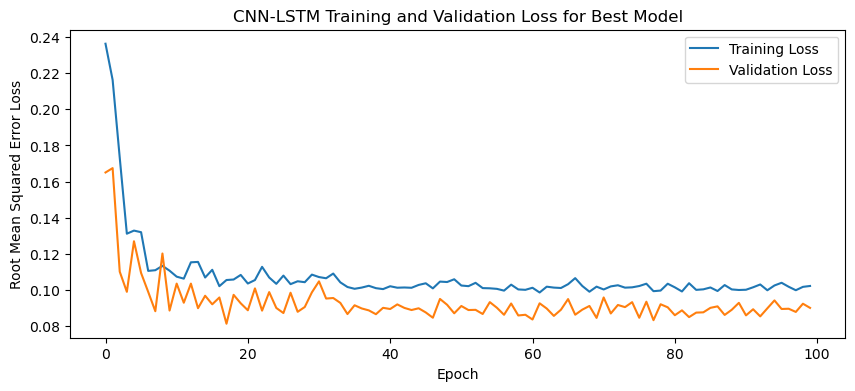

1/1 - 2s - loss: 0.1046 - 2s/epoch - 2s/step
Test Loss: 0.10459525138139725
Fold 2:
Epoch 1/100
19/19 [==============================] - 16s 342ms/step - loss: 0.2511 - val_loss: 0.1388
Epoch 2/100
19/19 [==============================] - 5s 242ms/step - loss: 0.2437 - val_loss: 0.1981
Epoch 3/100
19/19 [==============================] - 5s 253ms/step - loss: 0.1606 - val_loss: 0.1192
Epoch 4/100
19/19 [==============================] - 5s 263ms/step - loss: 0.1456 - val_loss: 0.0838
Epoch 5/100
19/19 [==============================] - 5s 242ms/step - loss: 0.1124 - val_loss: 0.0955
Epoch 6/100
19/19 [==============================] - 5s 261ms/step - loss: 0.1024 - val_loss: 0.0755
Epoch 7/100
19/19 [==============================] - 5s 261ms/step - loss: 0.1008 - val_loss: 0.0692
Epoch 8/100
19/19 [==============================] - 6s 337ms/step - loss: 0.0981 - val_loss: 0.0839
Epoch 9/100
19/19 [==============================] - 7s 365ms/step - loss: 0.1013 - val_loss: 0.0793
Epoch 

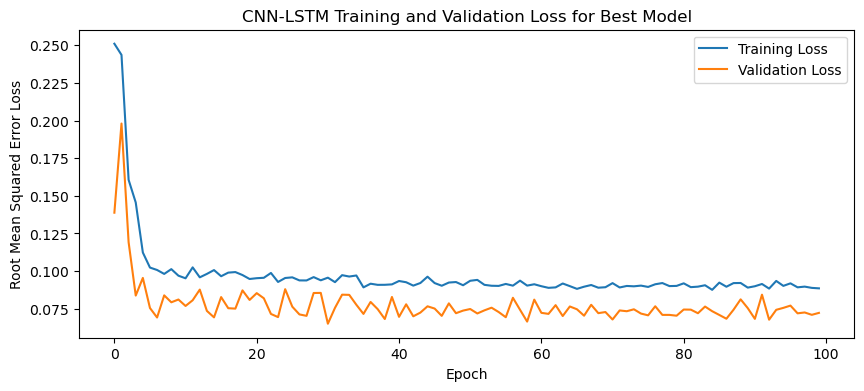

1/1 - 2s - loss: 0.0814 - 2s/epoch - 2s/step
Test Loss: 0.08143569529056549
Fold 3:
Epoch 1/100
19/19 [==============================] - 16s 385ms/step - loss: 0.2782 - val_loss: 0.2425
Epoch 2/100
19/19 [==============================] - 5s 266ms/step - loss: 0.1807 - val_loss: 0.1629
Epoch 3/100
19/19 [==============================] - 5s 247ms/step - loss: 0.1515 - val_loss: 0.1149
Epoch 4/100
19/19 [==============================] - 4s 228ms/step - loss: 0.1599 - val_loss: 0.1861
Epoch 5/100
19/19 [==============================] - 5s 237ms/step - loss: 0.1451 - val_loss: 0.0808
Epoch 6/100
19/19 [==============================] - 5s 269ms/step - loss: 0.1143 - val_loss: 0.1095
Epoch 7/100
19/19 [==============================] - 4s 228ms/step - loss: 0.1208 - val_loss: 0.0857
Epoch 8/100
19/19 [==============================] - 4s 205ms/step - loss: 0.1109 - val_loss: 0.0751
Epoch 9/100
19/19 [==============================] - 5s 284ms/step - loss: 0.1055 - val_loss: 0.0888
Epoch 

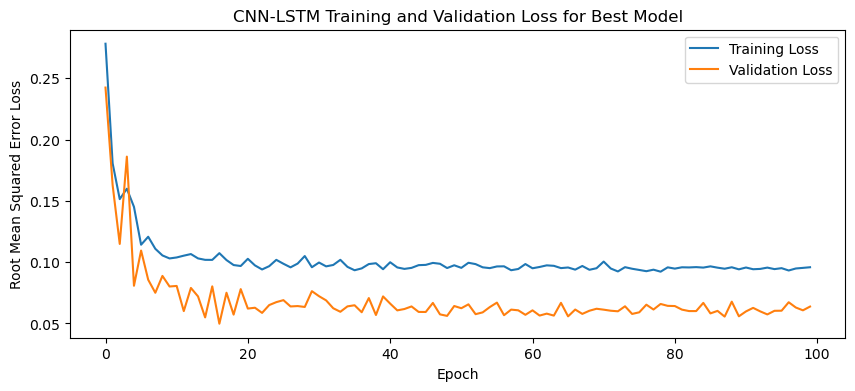

1/1 - 3s - loss: 0.0802 - 3s/epoch - 3s/step
Test Loss: 0.08015106618404388
Fold 4:
Epoch 1/100
20/20 [==============================] - 17s 362ms/step - loss: 0.3078 - val_loss: 0.1103
Epoch 2/100
20/20 [==============================] - 5s 242ms/step - loss: 0.1655 - val_loss: 0.2613
Epoch 3/100
20/20 [==============================] - 5s 243ms/step - loss: 0.1703 - val_loss: 0.2043
Epoch 4/100
20/20 [==============================] - 4s 217ms/step - loss: 0.1222 - val_loss: 0.1021
Epoch 5/100
20/20 [==============================] - 5s 255ms/step - loss: 0.1209 - val_loss: 0.1280
Epoch 6/100
20/20 [==============================] - 5s 228ms/step - loss: 0.1145 - val_loss: 0.1534
Epoch 7/100
20/20 [==============================] - 4s 228ms/step - loss: 0.1155 - val_loss: 0.1192
Epoch 8/100
20/20 [==============================] - 5s 260ms/step - loss: 0.1063 - val_loss: 0.1578
Epoch 9/100
20/20 [==============================] - 6s 283ms/step - loss: 0.1051 - val_loss: 0.1326
Epoch 

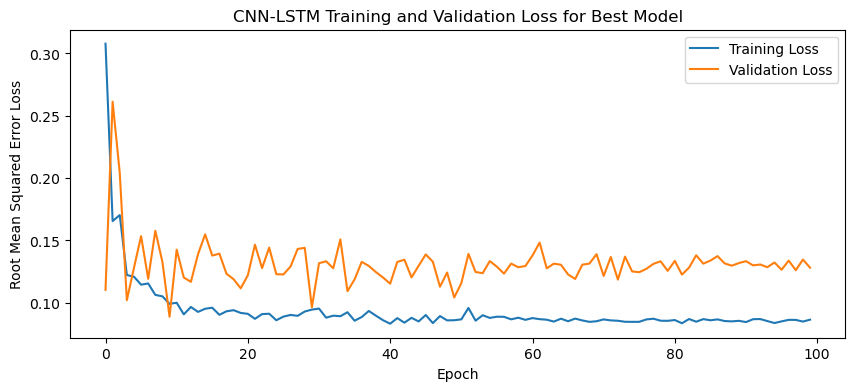

1/1 - 3s - loss: 0.1107 - 3s/epoch - 3s/step
Test Loss: 0.11067976802587509
Fold 5:
Epoch 1/100
19/19 [==============================] - 18s 357ms/step - loss: 0.2856 - val_loss: 0.1288
Epoch 2/100
19/19 [==============================] - 3s 158ms/step - loss: 0.1808 - val_loss: 0.2106
Epoch 3/100
19/19 [==============================] - 3s 167ms/step - loss: 0.1434 - val_loss: 0.1800
Epoch 4/100
19/19 [==============================] - 3s 168ms/step - loss: 0.1402 - val_loss: 0.1422
Epoch 5/100
19/19 [==============================] - 4s 221ms/step - loss: 0.1137 - val_loss: 0.1437
Epoch 6/100
19/19 [==============================] - 4s 195ms/step - loss: 0.1179 - val_loss: 0.1385
Epoch 7/100
19/19 [==============================] - 4s 200ms/step - loss: 0.0999 - val_loss: 0.1238
Epoch 8/100
19/19 [==============================] - 5s 265ms/step - loss: 0.0905 - val_loss: 0.1473
Epoch 9/100
19/19 [==============================] - 4s 221ms/step - loss: 0.0972 - val_loss: 0.1395
Epoch 

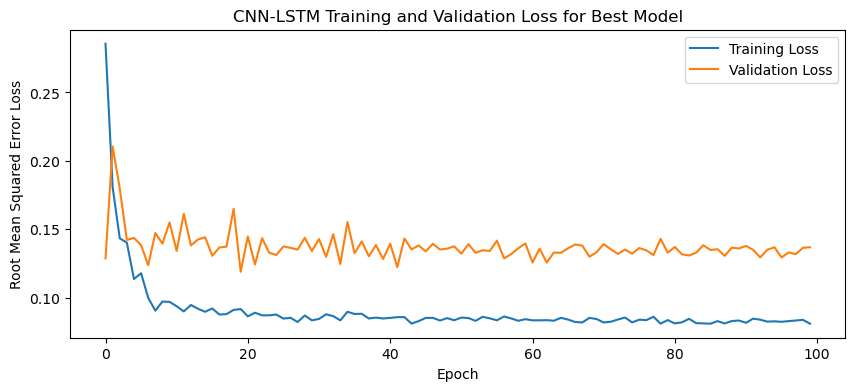

1/1 - 3s - loss: 0.0740 - 3s/epoch - 3s/step
Test Loss: 0.07400569319725037


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

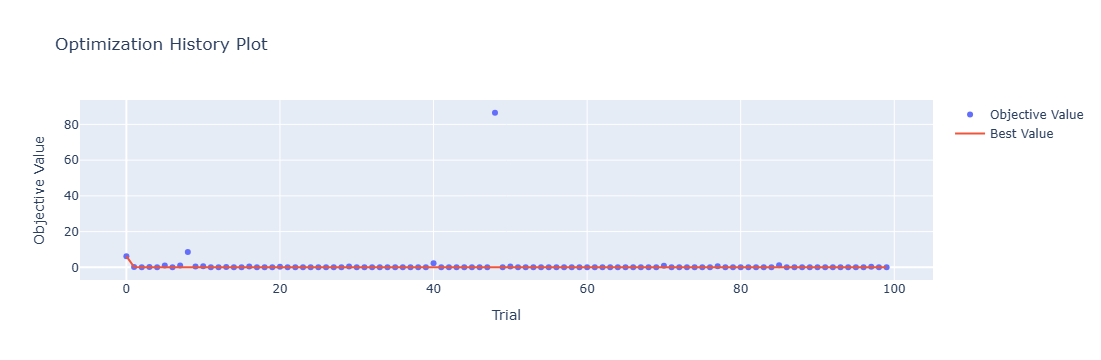

In [4]:
optuna.visualization.plot_optimization_history(study)

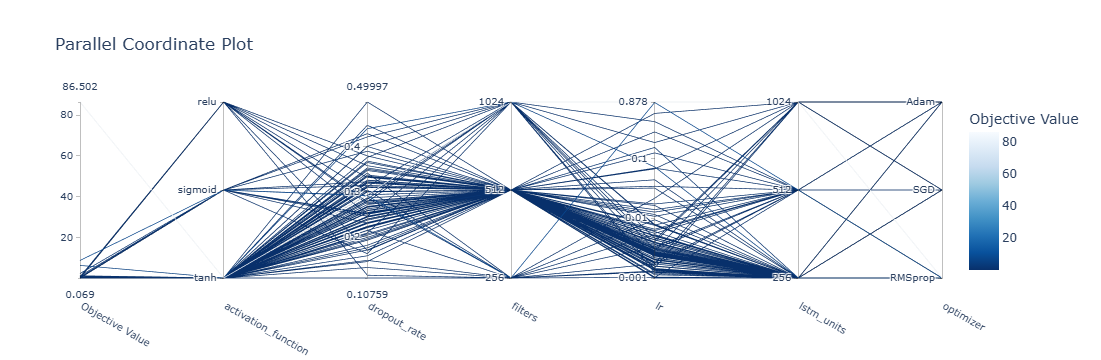

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

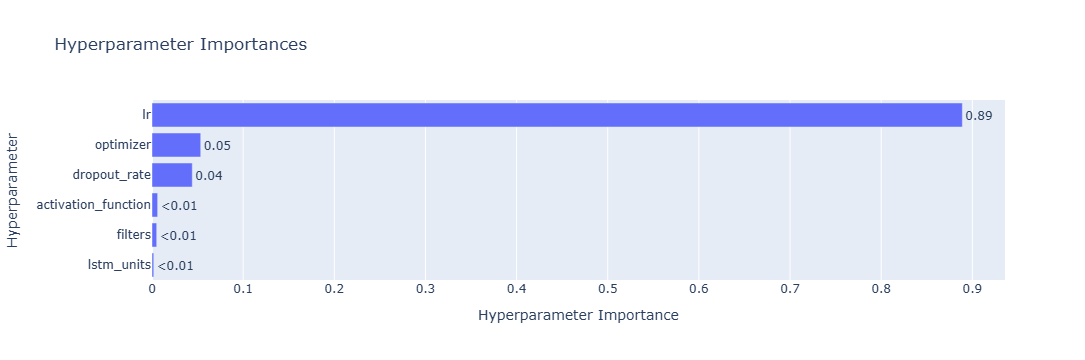

In [6]:
optuna.visualization.plot_param_importances(study)

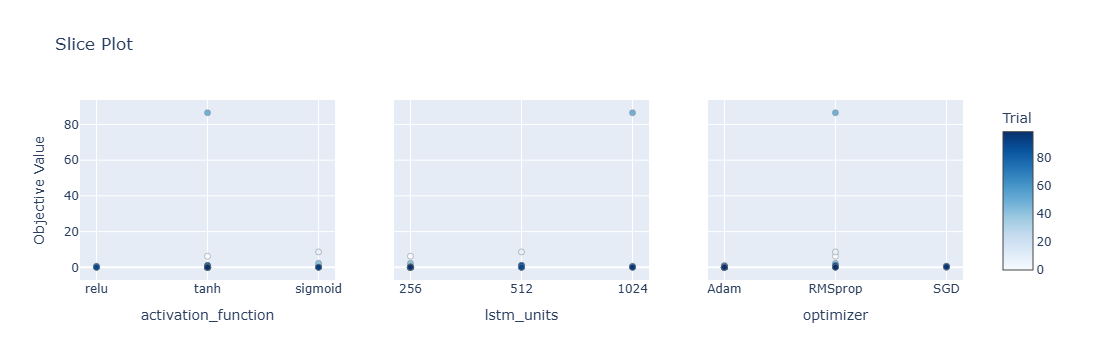

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

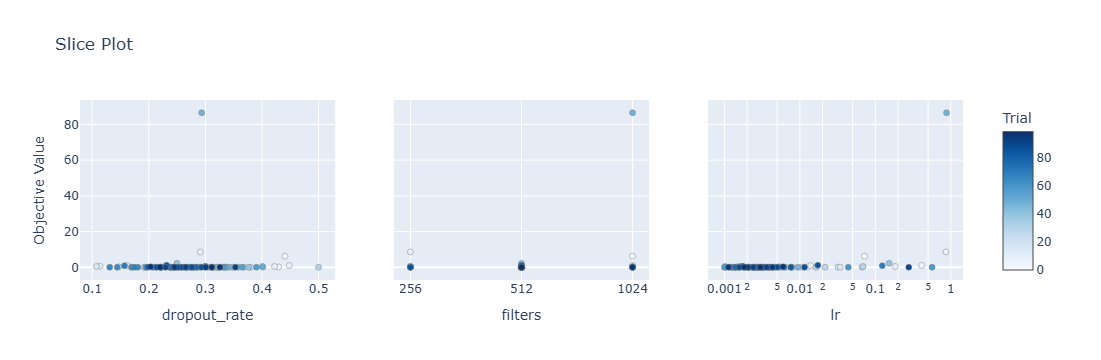

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 21s 336ms/step - loss: 0.2794 - accuracy: 0.3158 - mae: 0.2433 - rmse: 0.2794 - mape: 44.7042 - pearson: 0.2618 - val_loss: 0.1560 - val_accuracy: 0.3333 - val_mae: 0.1298 - val_rmse: 0.1560 - val_mape: 22.0114 - val_pearson: 0.1693
Epoch 2/100
19/19 [==============================] - 3s 156ms/step - loss: 0.1708 - accuracy: 0.3684 - mae: 0.1413 - rmse: 0.1708 - mape: 26.8696 - pearson: 0.3156 - val_loss: 0.2093 - val_accuracy: 0.0000e+00 - val_mae: 0.1881 - val_rmse: 0.2093 - val_mape: 32.3816 - val_pearson: 0.4501
Epoch 3/100
19/19 [==============================] - 2s 122ms/step - loss: 0.2004 - ac

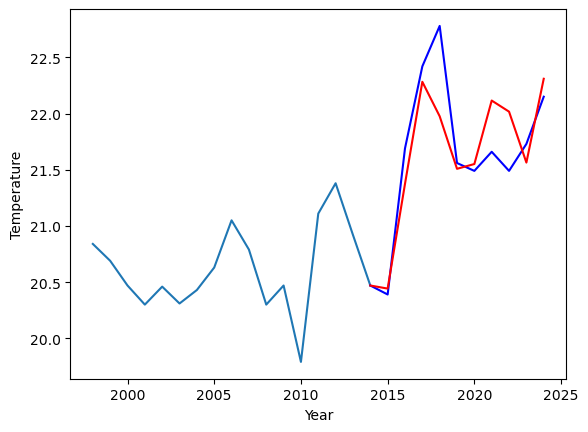

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.37		16.17		-0.20
17.64		17.10		-0.54
17.80		18.01		0.21
18.04		17.71		-0.33
18.00		17.24		-0.76
18.95		17.28		-1.67
18.12		17.85		-0.27
17.61		17.75		0.14
17.89		17.29		-0.60
17.72		18.04		0.32


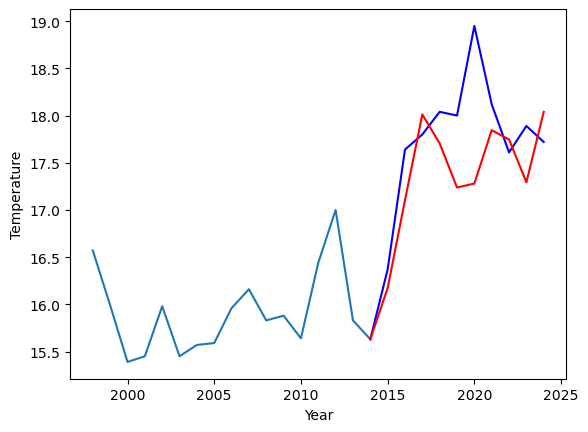

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.39  20.442598
1                1   16.37  16.172409


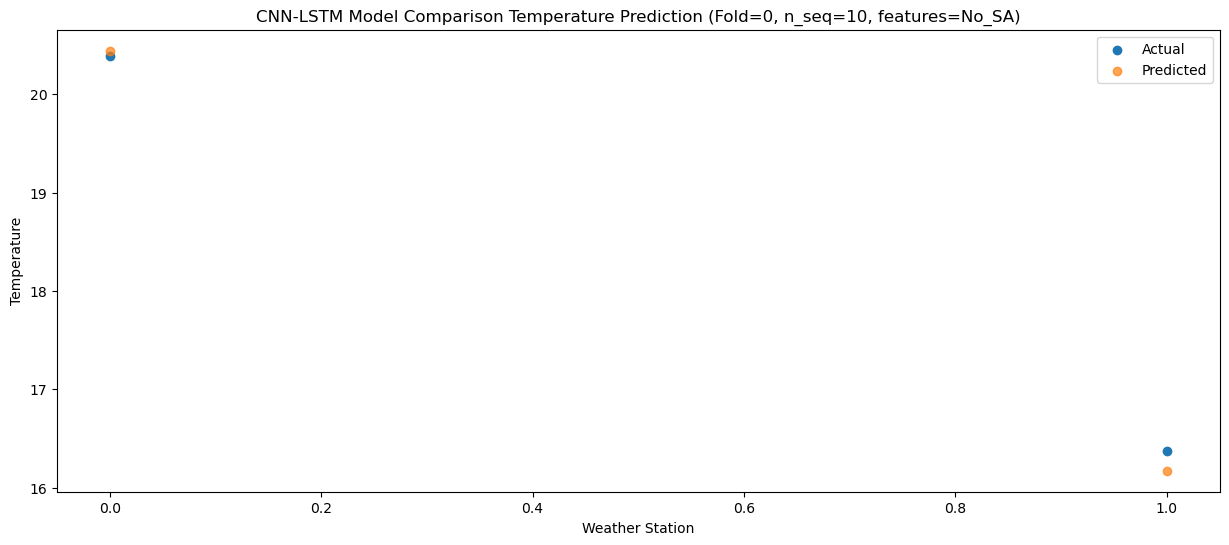

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.69  21.374516
1                1   17.64  17.104256


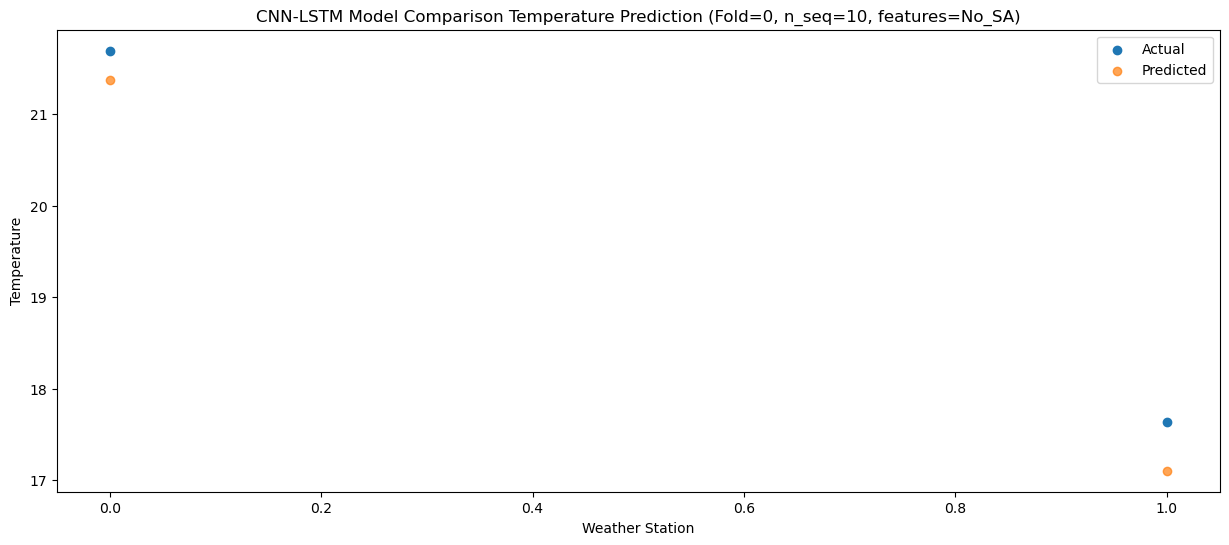

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.42  22.282739
1                1   17.80  18.012025


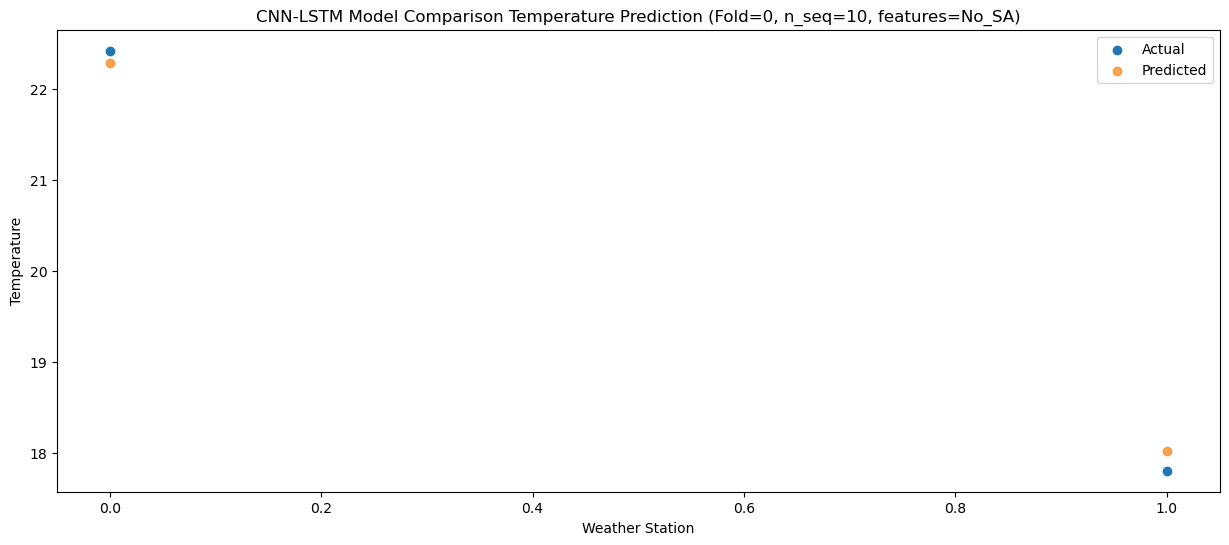

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.78  21.976031
1                1   18.04  17.705096


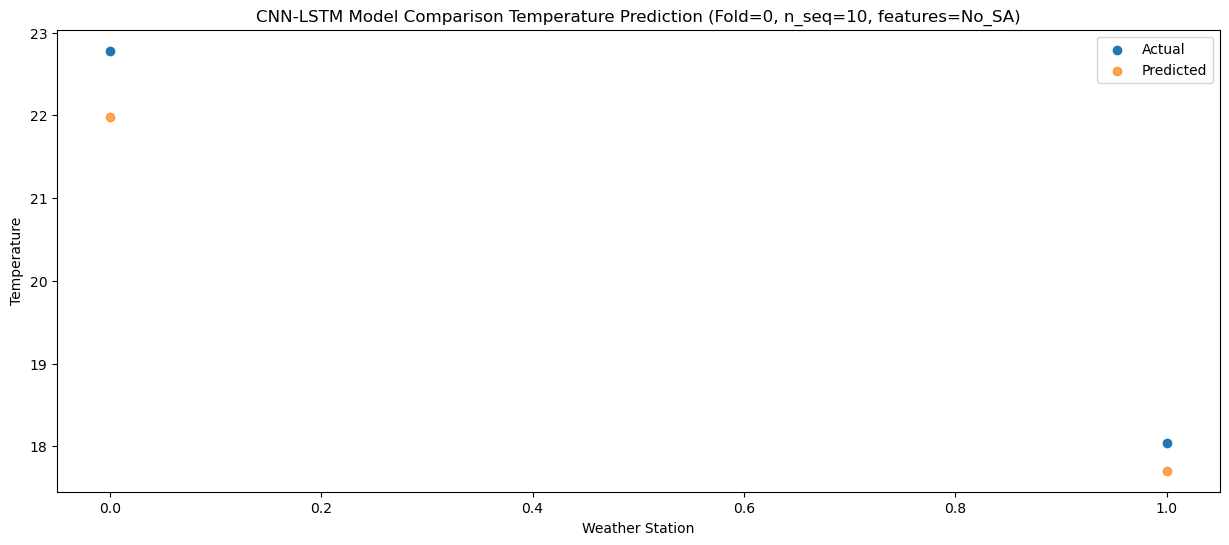

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.56  21.508543
1                1   18.00  17.237646


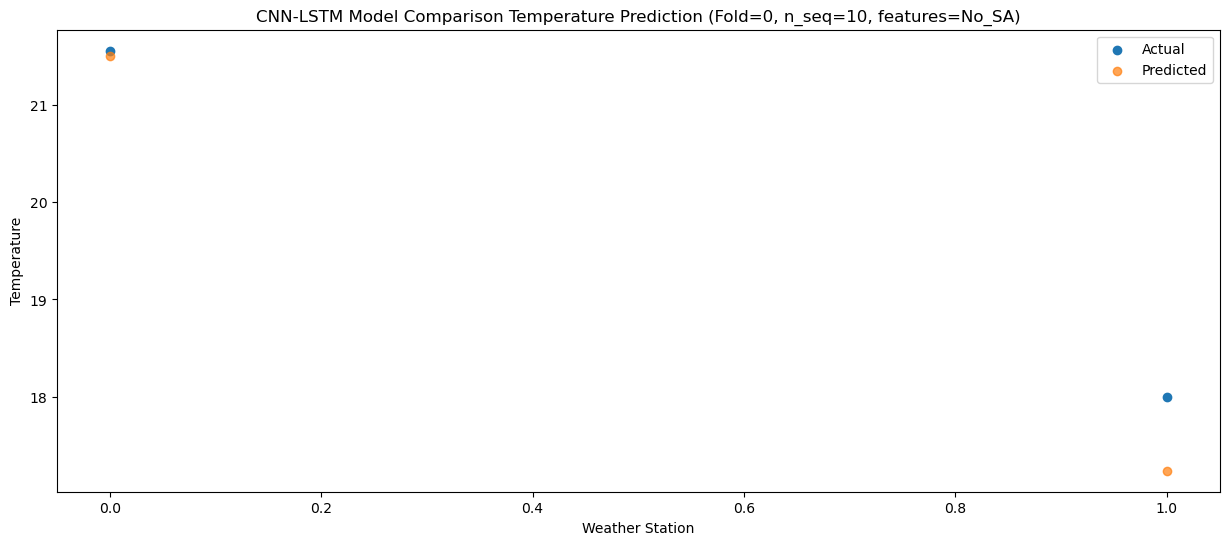

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.49  21.551032
1                1   18.95  17.280431


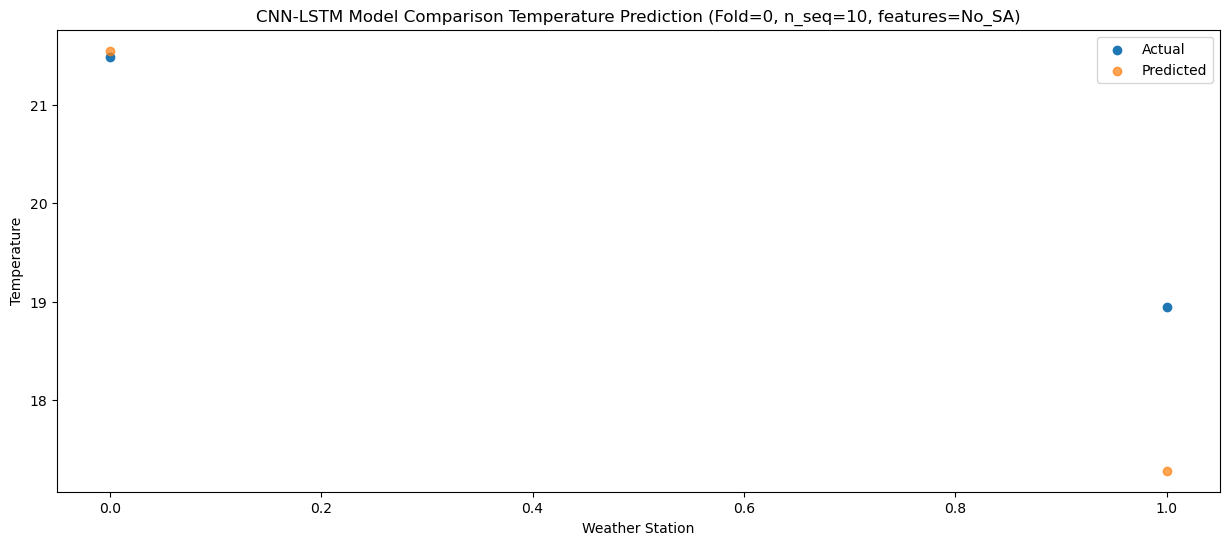

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   21.66  22.115870
1                1   18.12  17.845331


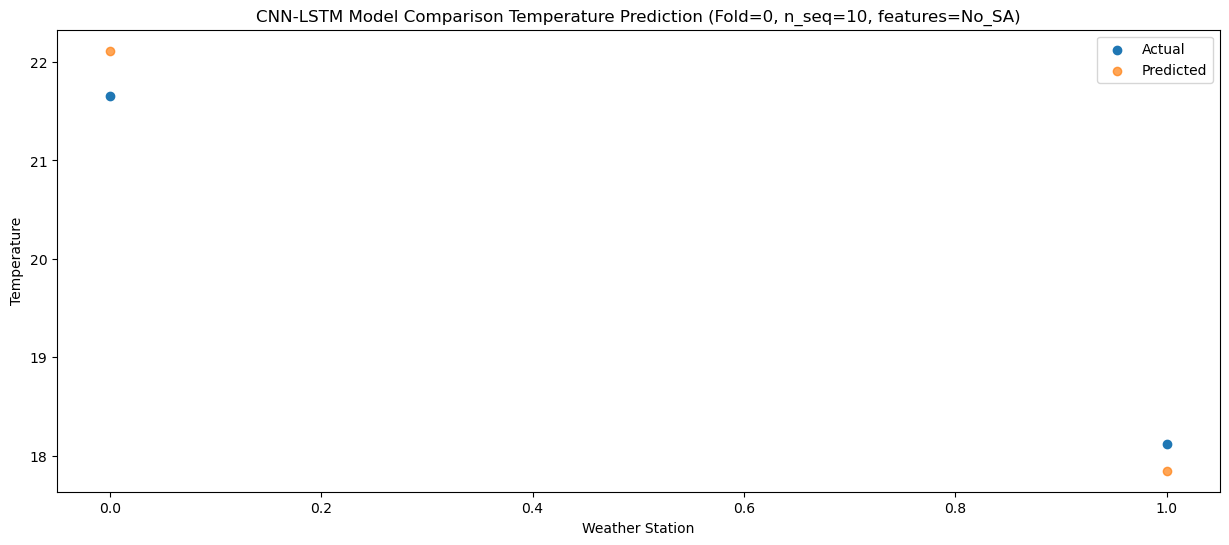

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.49  22.017088
1                1   17.61  17.746480


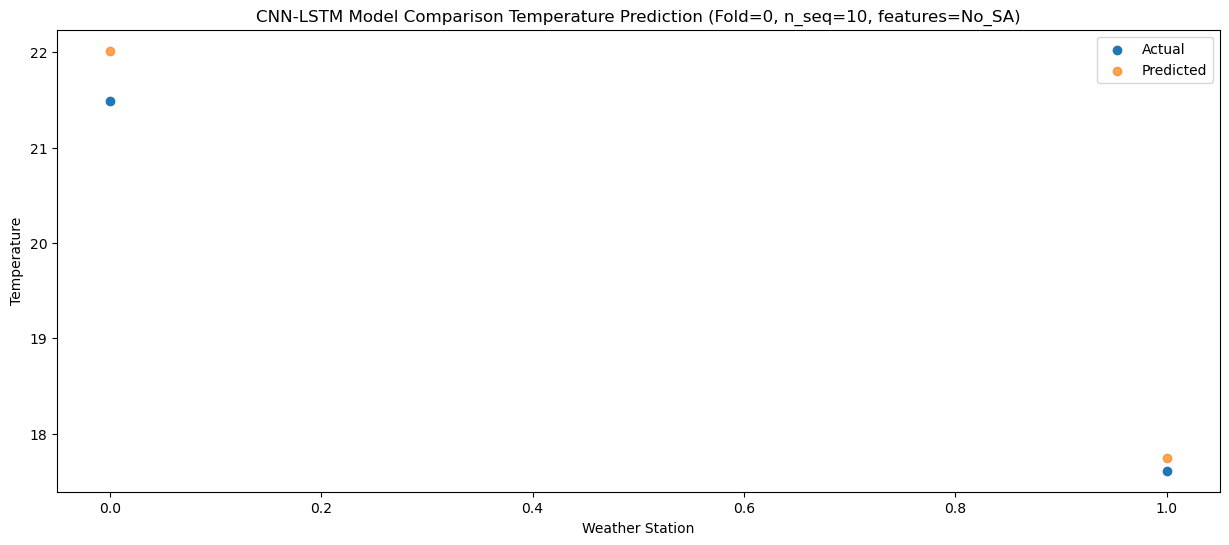

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   21.73  21.563951
1                1   17.89  17.293438


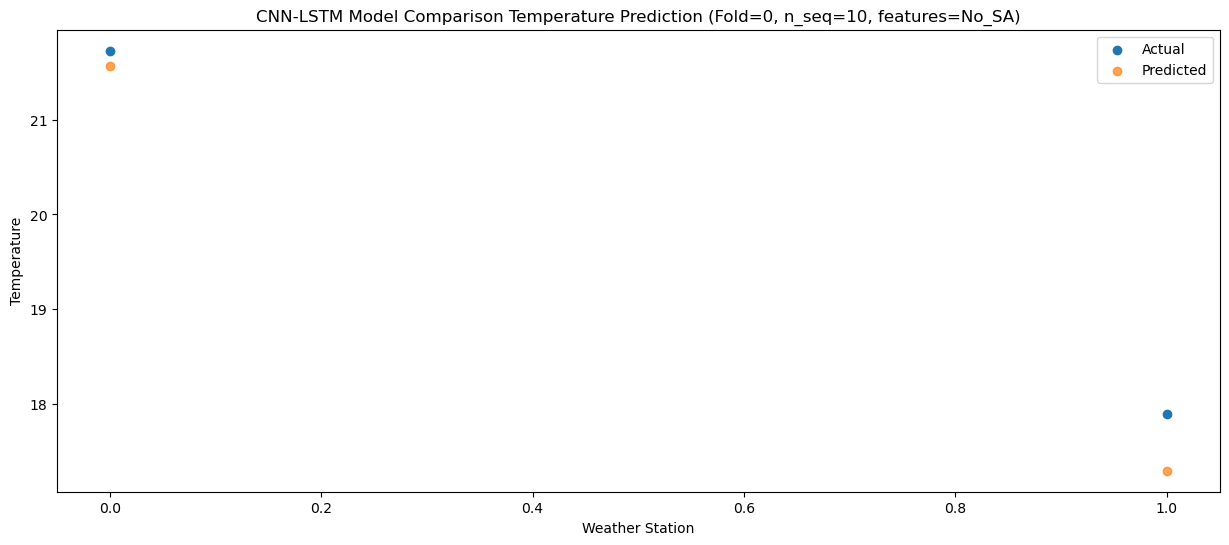

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   22.15  22.309800
1                1   17.72  18.039314


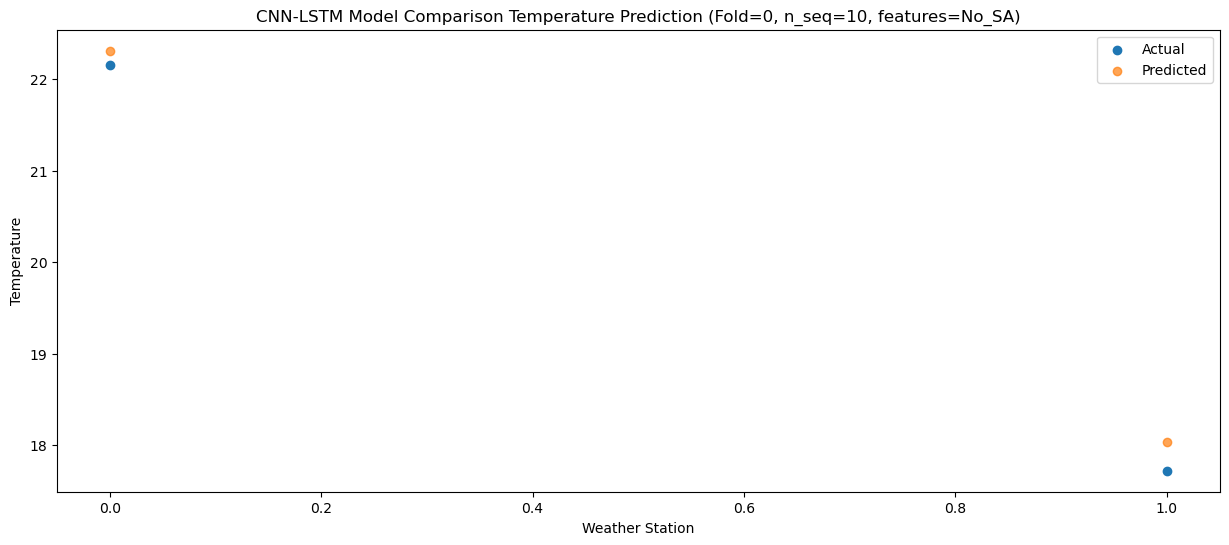

f, t:
[[20.39 16.37]
 [21.69 17.64]
 [22.42 17.8 ]
 [22.78 18.04]
 [21.56 18.  ]
 [21.49 18.95]
 [21.66 18.12]
 [21.49 17.61]
 [21.73 17.89]
 [22.15 17.72]]
[[20.44259846 16.17240948]
 [21.37451589 17.10425574]
 [22.28273862 18.01202471]
 [21.97603058 17.7050956 ]
 [21.50854304 17.23764617]
 [21.55103237 17.28043134]
 [22.11586977 17.84533078]
 [22.01708766 17.74648046]
 [21.56395131 17.29343787]
 [22.30980044 18.03931436]]
Year at t+1:
t+1 SKRMSE: 0.144583
t+1 KRMSE: 0.144583
t+1 MAE: 0.125094
t+1 SKMAPE: 0.007325
t+1 R2_SCORE: 0.994826
t+1 KMAPE: 0.007325
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.439632
t+2 KRMSE: 0.439632
t+2 MAE: 0.425614
t+2 SKMAPE: 0.022458
t+2 R2_SCORE: 0.952867
t+2 KMAPE: 0.022458
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.178599
t+3 KRMSE: 0.178599
t+3 MAE: 0.174643
t+3 SKMAPE: 0.009017
t+3 R2_SCORE: 0.994022
t+3 KMAPE: 0.009017
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.615844
t+4 KRMSE: 0.615844
t+4 MAE: 0.569437
t+4 SKMAPE: 0.026929
t+4 R

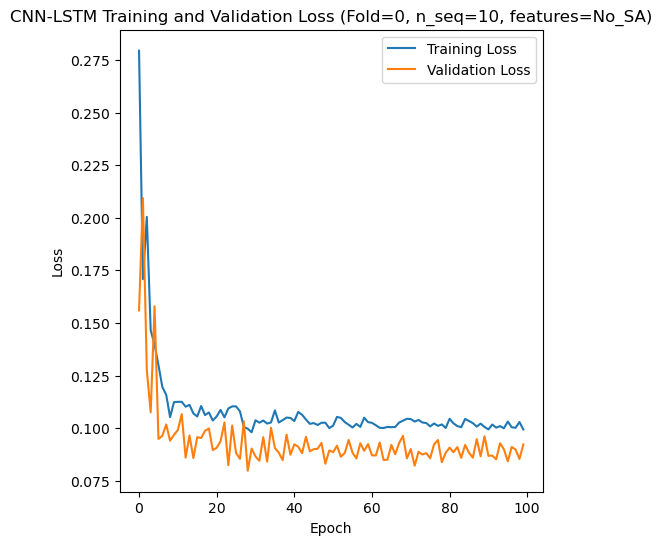

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 18s 320ms/step - loss: 0.3105 - accuracy: 0.1053 - mae: 0.2762 - rmse: 0.3105 - mape: 44.6256 - pearson: 0.1971 - val_loss: 0.1645 - val_accuracy: 1.0000 - val_mae: 0.1377 - val_rmse: 0.1645 - val_mape: 24.8103 - val_pearson: 0.1268
Epoch 2/100
19/19 [==============================] - 4s 196ms/step - loss: 0.1665 - accuracy: 0.2632 - mae: 0.1432 - rmse: 0.1665 - mape: 23.4530 - pearson: 0.2971 - val_loss: 0.1415 - val_accuracy: 1.0000 - val_mae: 0.1167 - val_rmse: 0.1415 - val_mape: 21.1742 - val_pearson: 0.2286
Epoch 3/100
19/19 [==============================] - 3s 137ms/step - loss: 0.1554 - accurac

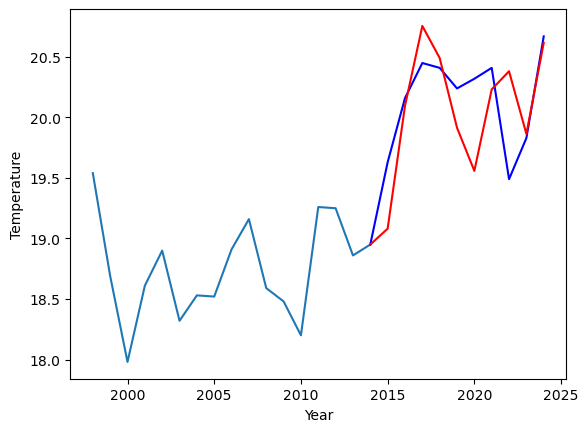

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.88		19.23		-0.65
19.40		20.25		0.85
20.43		20.91		0.48
20.81		20.64		-0.17
19.96		20.07		0.11
20.09		19.71		-0.38
20.61		20.38		-0.23
20.22		20.53		0.31
20.22		20.01		-0.21
21.53		20.77		-0.76


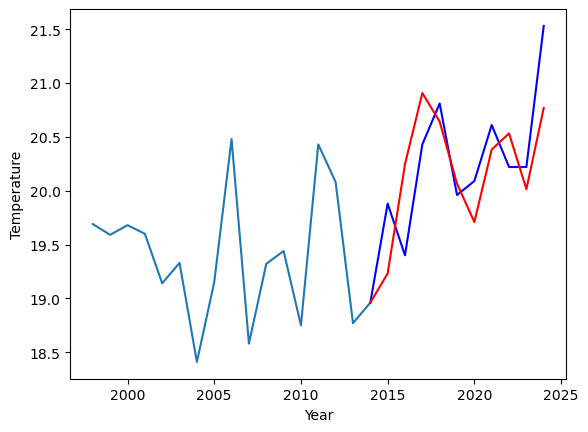

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.63  19.081163
1                1   19.88  19.231171


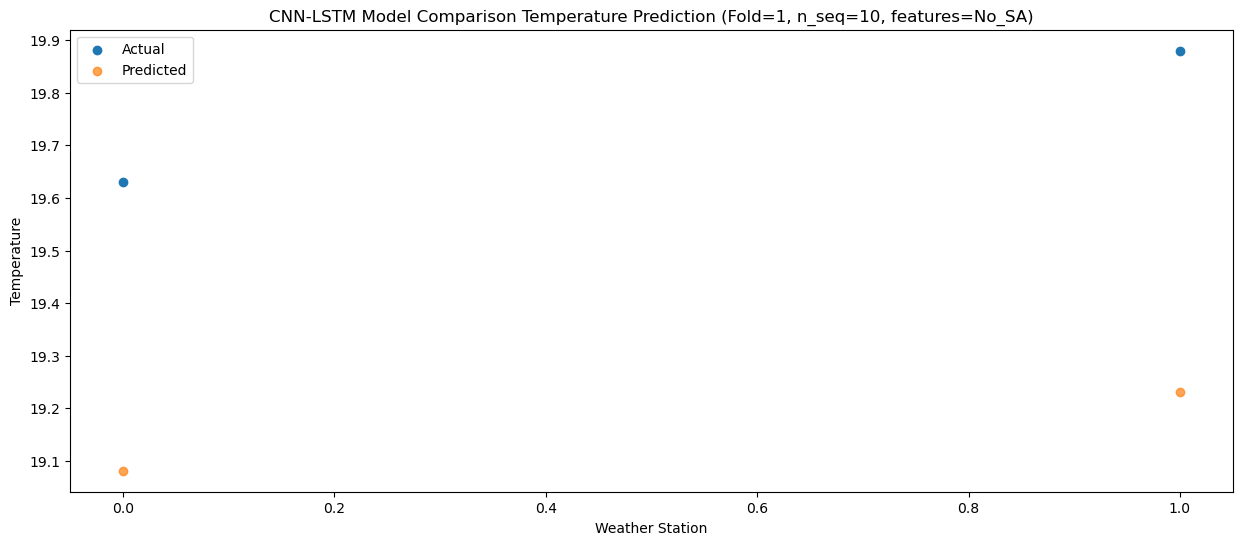

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.16  20.096596
1                1   19.40  20.246634


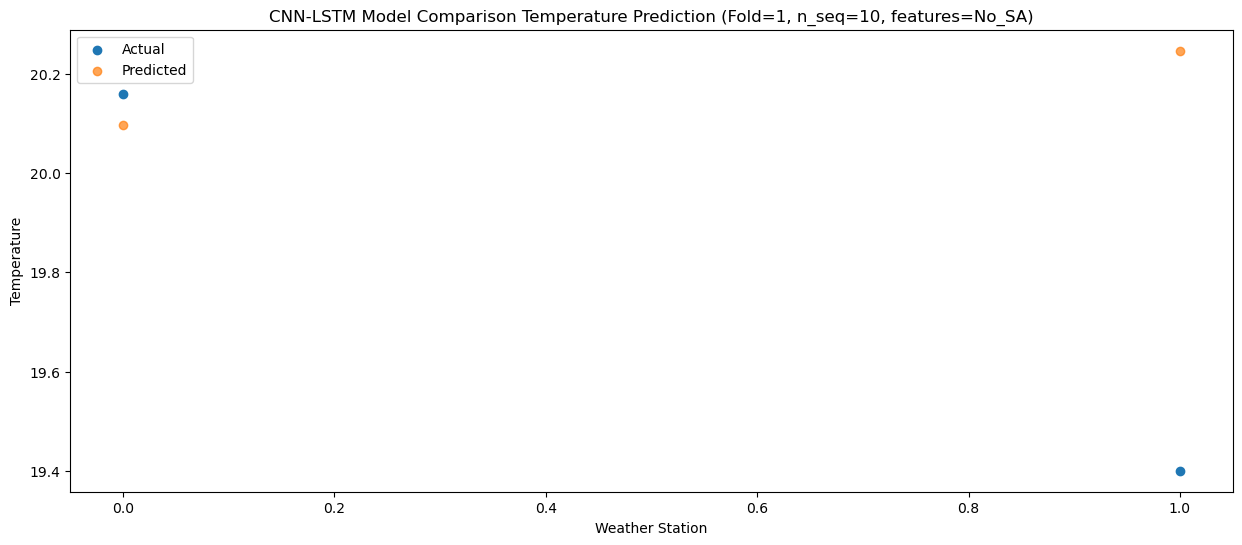

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.45  20.756580
1                1   20.43  20.906639


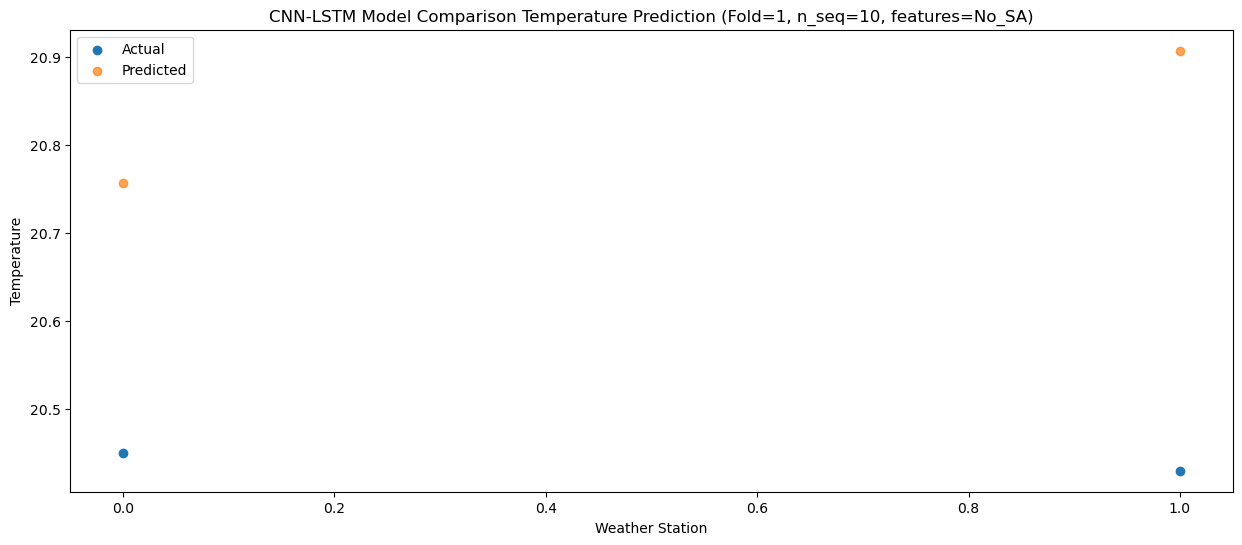

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   20.41  20.491466
1                1   20.81  20.641543


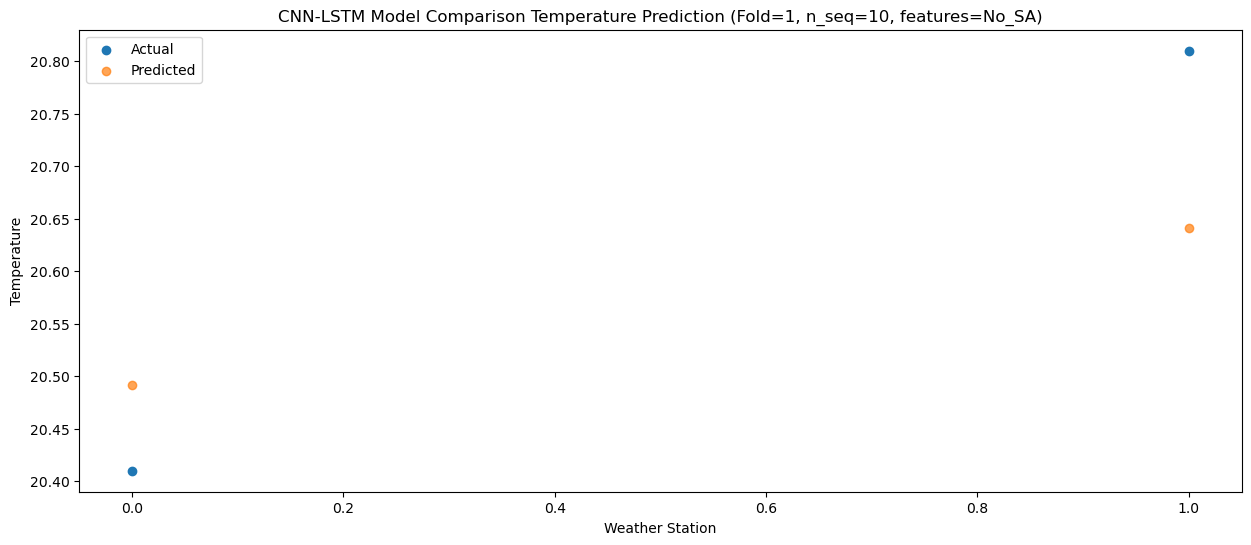

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   20.24  19.915067
1                1   19.96  20.065147


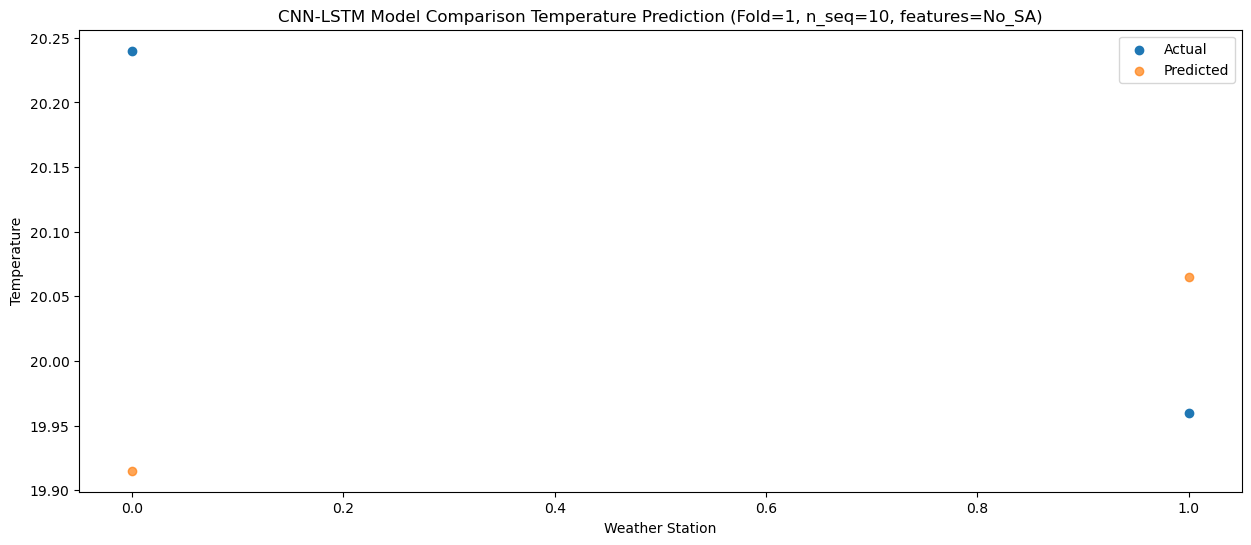

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   20.32  19.558615
1                1   20.09  19.708685


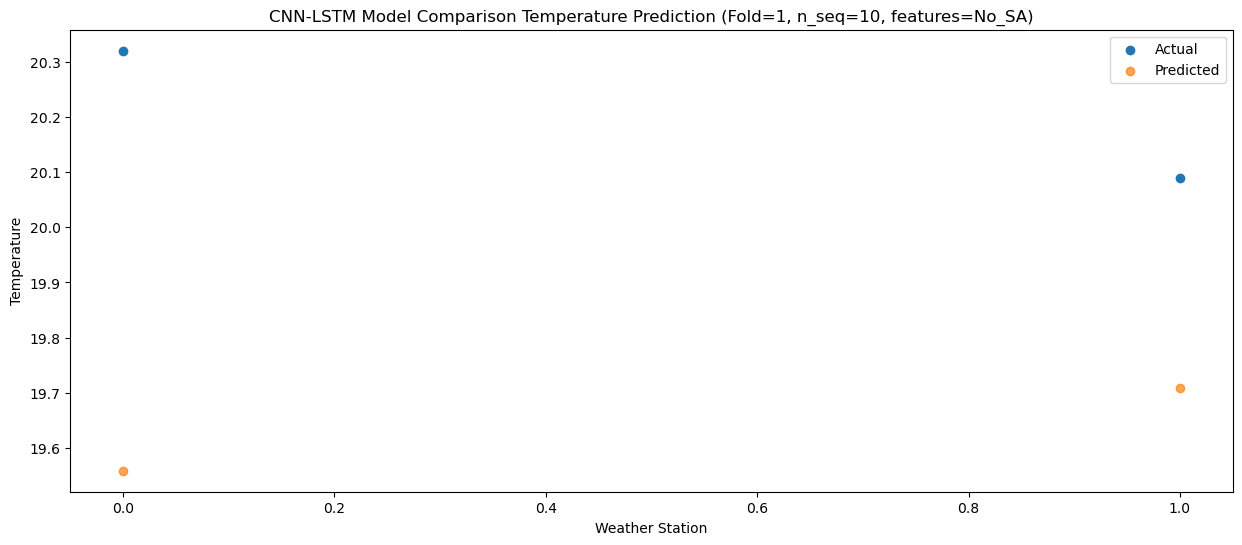

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   20.41  20.232160
1                1   20.61  20.382259


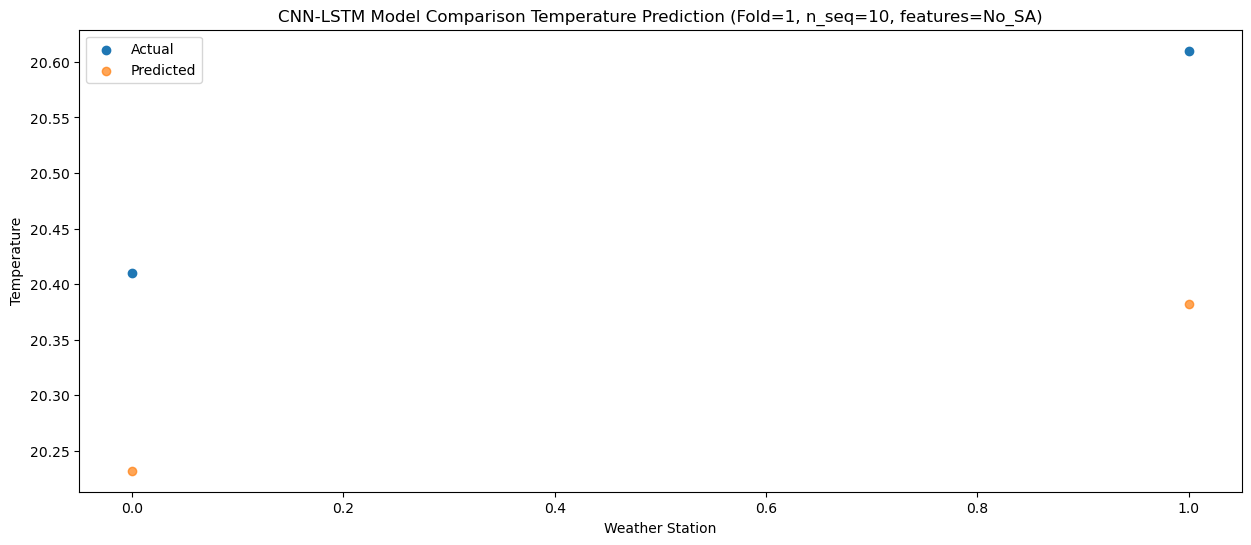

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   19.49  20.382036
1                1   20.22  20.532158


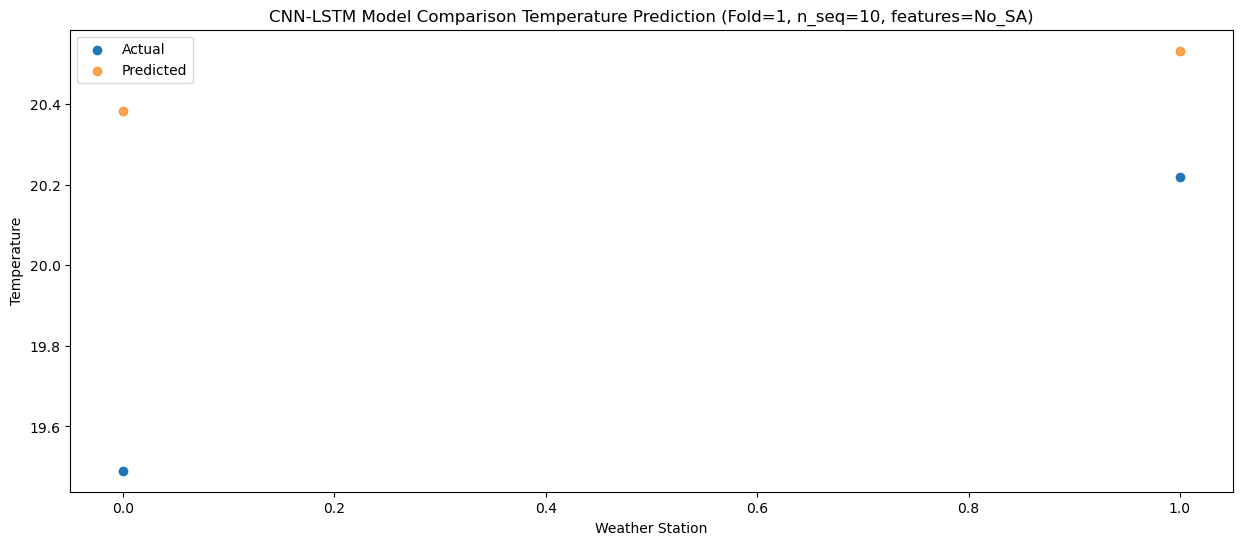

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   19.83  19.864240
1                1   20.22  20.014354


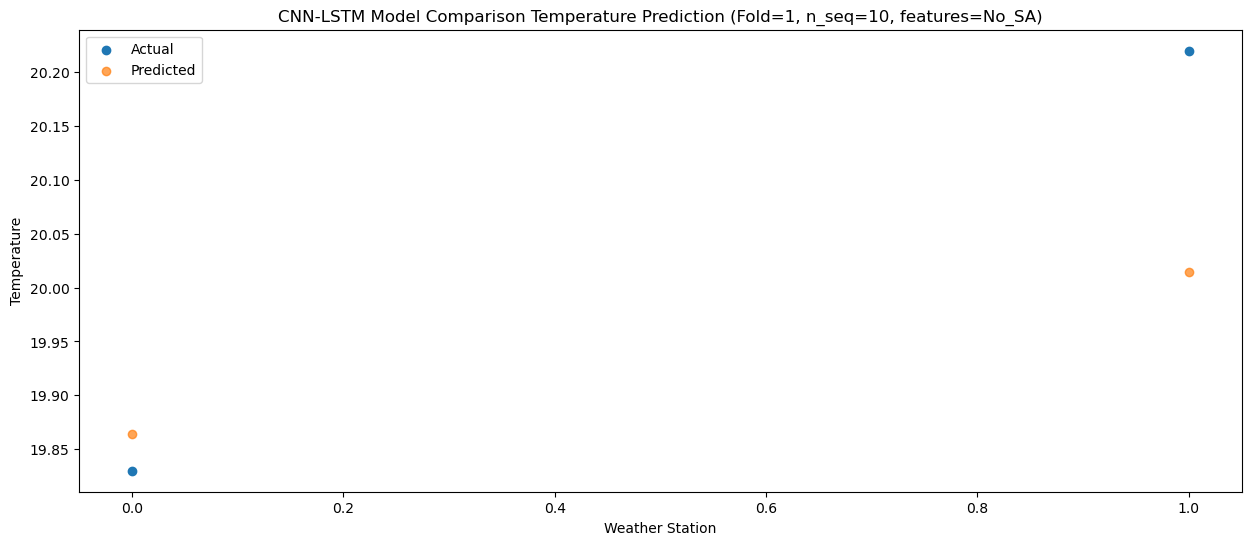

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   20.67  20.617430
1                1   21.53  20.767521


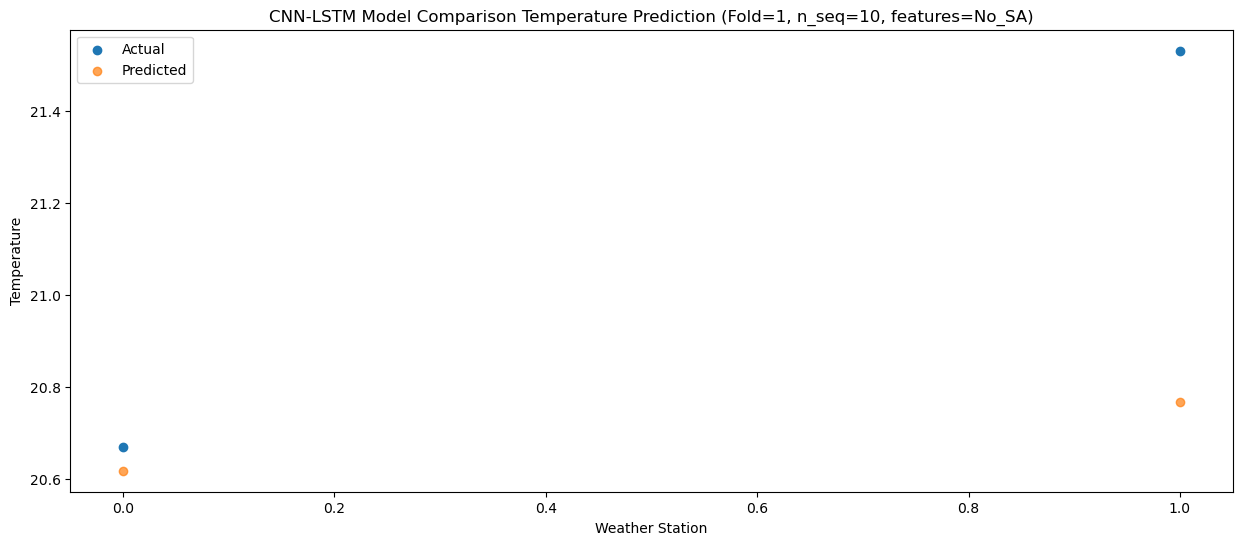

f, t:
[[19.63 19.88]
 [20.16 19.4 ]
 [20.45 20.43]
 [20.41 20.81]
 [20.24 19.96]
 [20.32 20.09]
 [20.41 20.61]
 [19.49 20.22]
 [19.83 20.22]
 [20.67 21.53]]
[[19.08116279 19.23117075]
 [20.09659598 20.24663374]
 [20.75657985 20.90663943]
 [20.49146579 20.64154297]
 [19.91506664 20.06514675]
 [19.55861504 19.70868466]
 [20.23215962 20.38225863]
 [20.38203558 20.53215808]
 [19.86424013 20.01435381]
 [20.61743005 20.76752109]]
Year at t+1:
t+1 SKRMSE: 0.600917
t+1 KRMSE: 0.600917
t+1 MAE: 0.598833
t+1 SKMAPE: 0.030298
t+1 R2_SCORE: -22.110454
t+1 KMAPE: 0.030298
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.600337
t+2 KRMSE: 0.600337
t+2 MAE: 0.455019
t+2 SKMAPE: 0.023393
t+2 R2_SCORE: -1.495875
t+2 KMAPE: 0.023393
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.400735
t+3 KRMSE: 0.400735
t+3 MAE: 0.391610
t+3 SKMAPE: 0.019161
t+3 R2_SCORE: -1604.881764
t+3 KMAPE: 0.019161
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.132315
t+4 KRMSE: 0.132315
t+4 MAE: 0.124961
t+4 SKMAPE: 0.00604

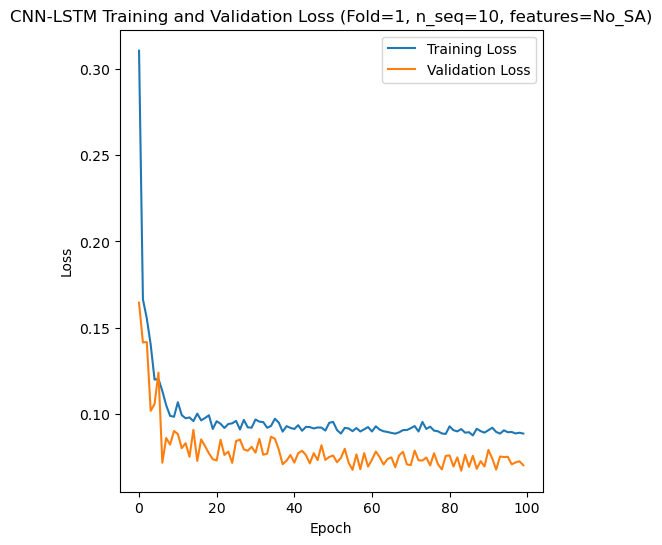

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 26s 407ms/step - loss: 0.2949 - accuracy: 0.0526 - mae: 0.2544 - rmse: 0.2949 - mape: 40.4904 - pearson: 0.1357 - val_loss: 0.1803 - val_accuracy: 0.0000e+00 - val_mae: 0.1477 - val_rmse: 0.1803 - val_mape: 23.0580 - val_pearson: 0.1975
Epoch 2/100
19/19 [==============================] - 2s 130ms/step - loss: 0.2080 - accuracy: 0.3158 - mae: 0.1692 - rmse: 0.2080 - mape: 26.8316 - pearson: 0.0991 - val_loss: 0.1048 - val_accuracy: 0.0000e+00 - val_mae: 0.0815 - val_rmse: 0.1048 - val_mape: 13.8606 - val_pearson: 0.0910
Epoch 3/100
19/19 [==============================] - 3s 138ms/step - loss: 0.1536 -

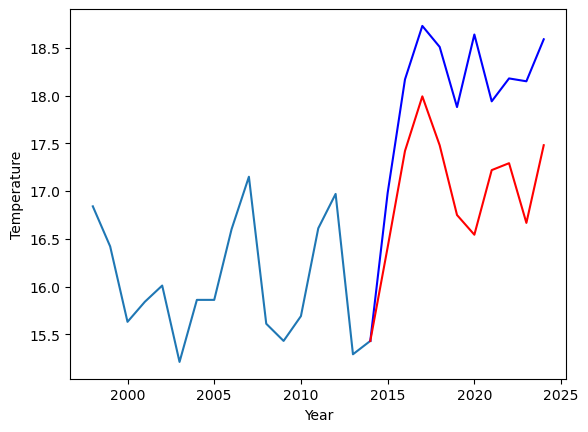

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.89		13.08		0.19
14.23		14.09		-0.14
15.00		14.66		-0.34
14.82		14.15		-0.67
14.35		13.42		-0.93
14.68		13.21		-1.47
14.67		13.89		-0.78
14.66		13.96		-0.70
14.20		13.34		-0.86
14.99		14.15		-0.84


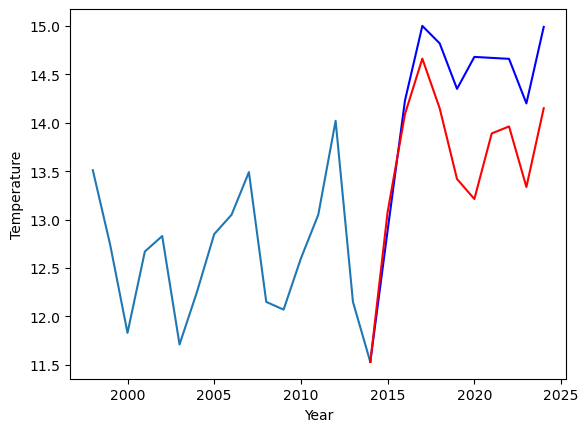

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.98  16.410644
1                1   12.89  13.080644


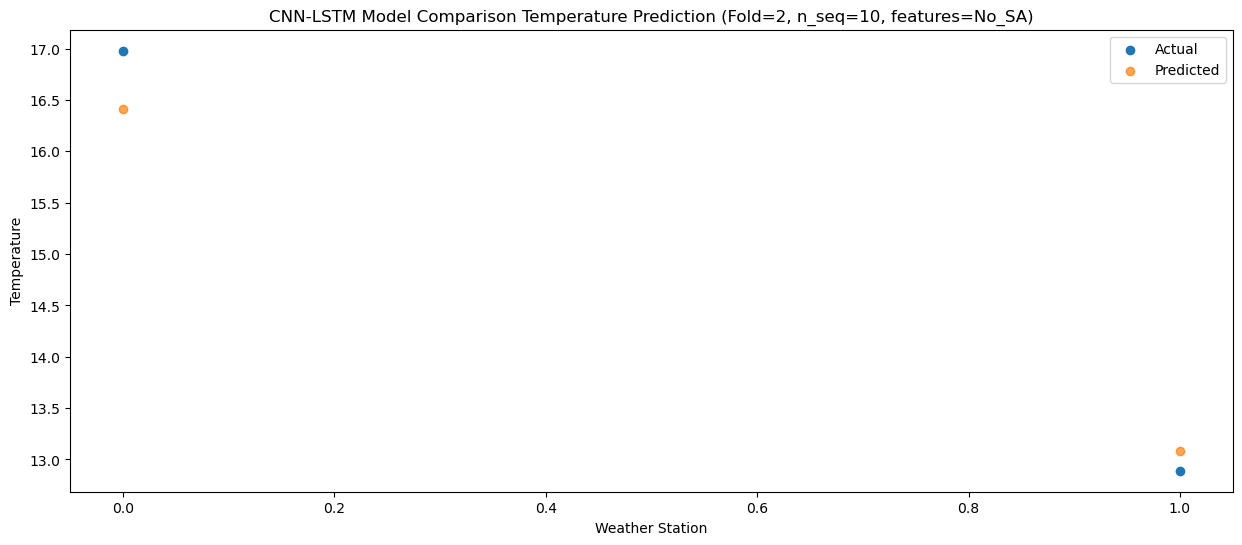

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   18.17  17.420337
1                1   14.23  14.090337


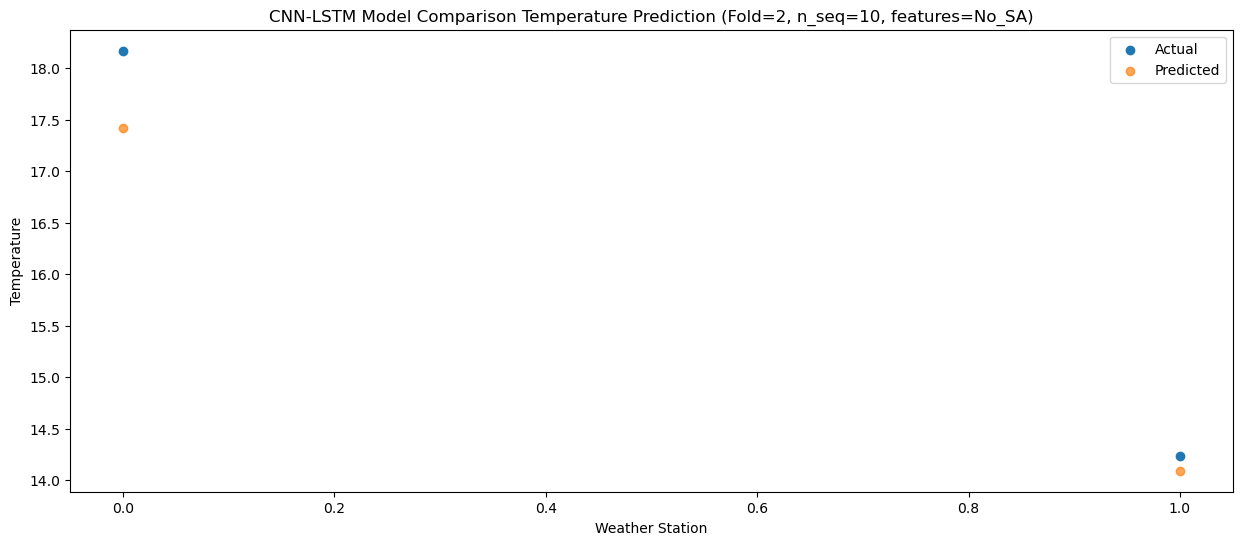

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.73  17.992168
1                1   15.00  14.662168


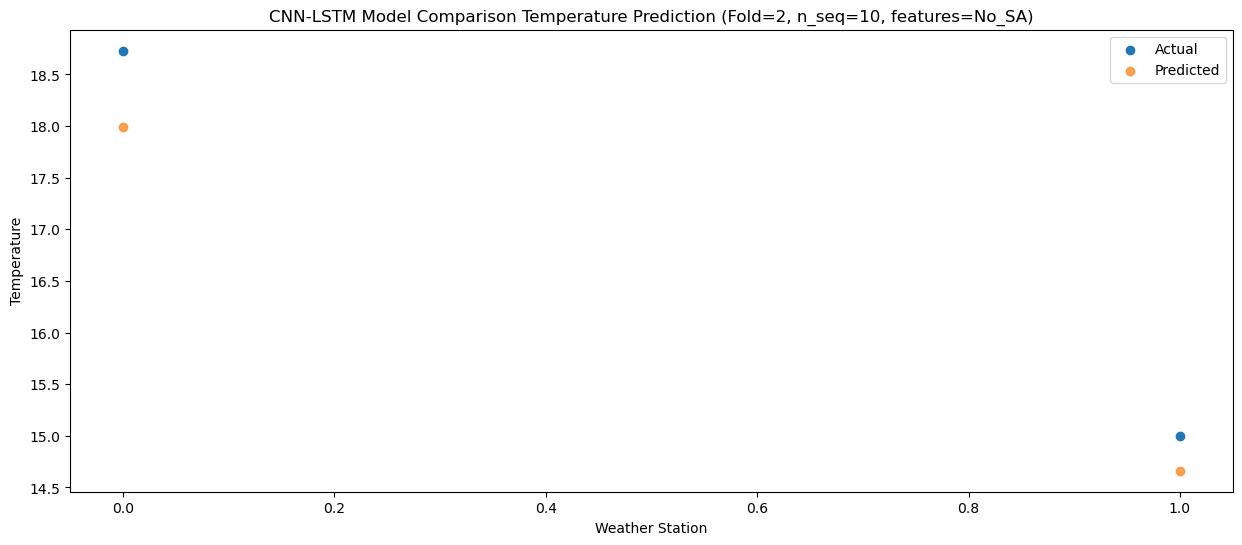

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   18.51   17.47966
1                1   14.82   14.14966


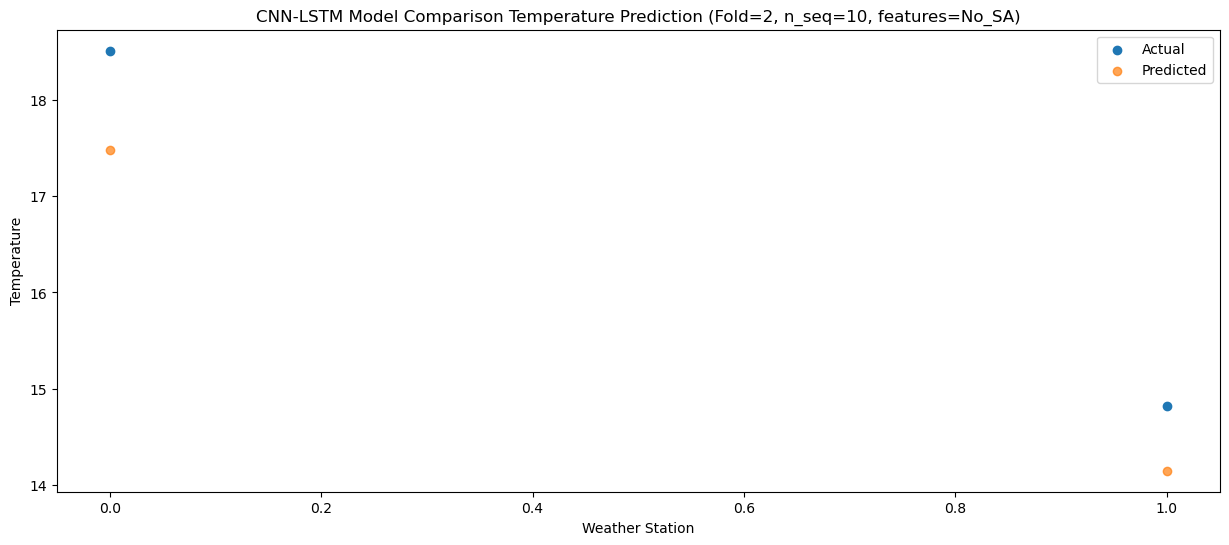

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.88  16.748945
1                1   14.35  13.418945


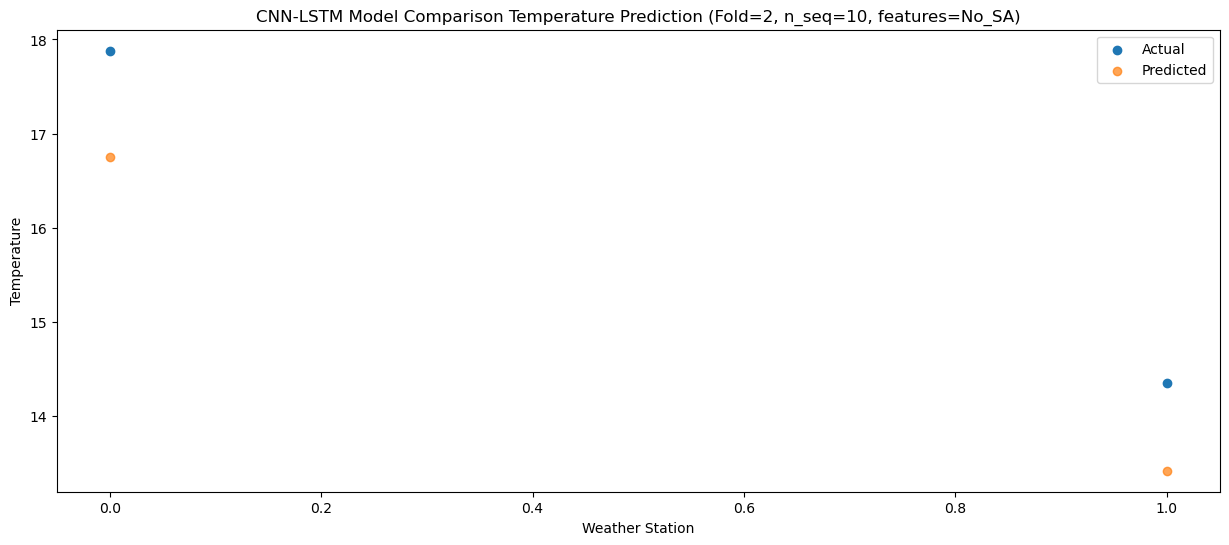

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   18.64  16.542559
1                1   14.68  13.212559


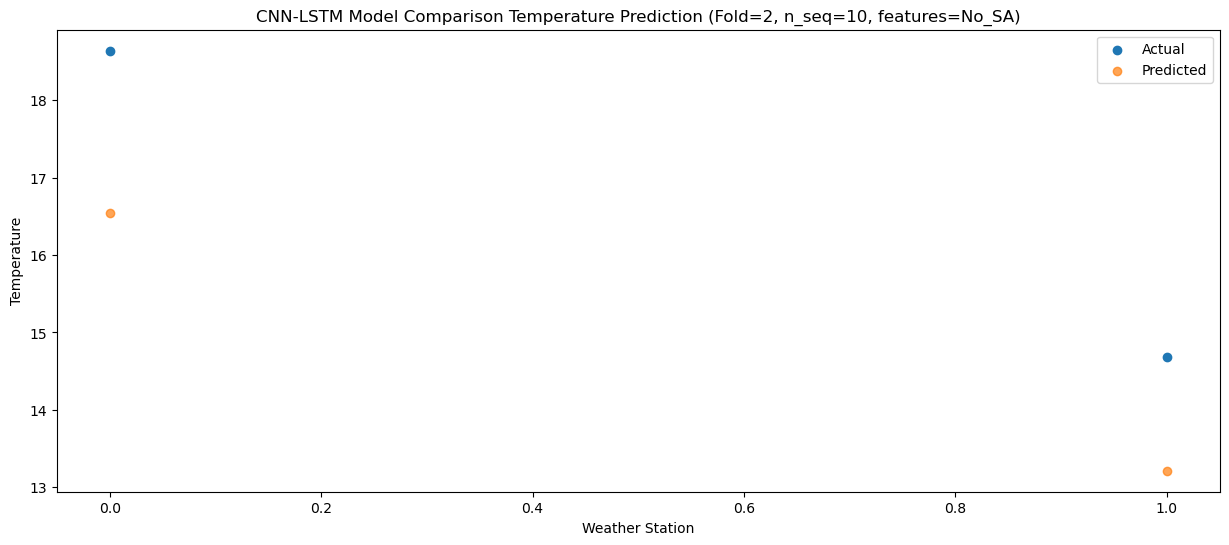

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   17.94  17.219392
1                1   14.67  13.889392


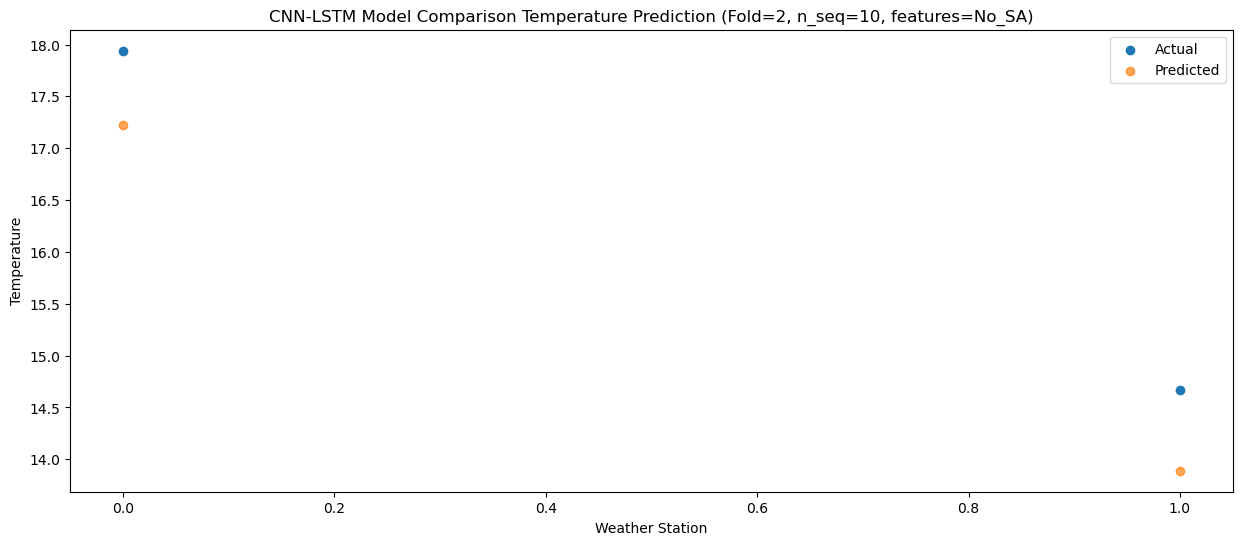

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   18.18  17.291892
1                1   14.66  13.961892


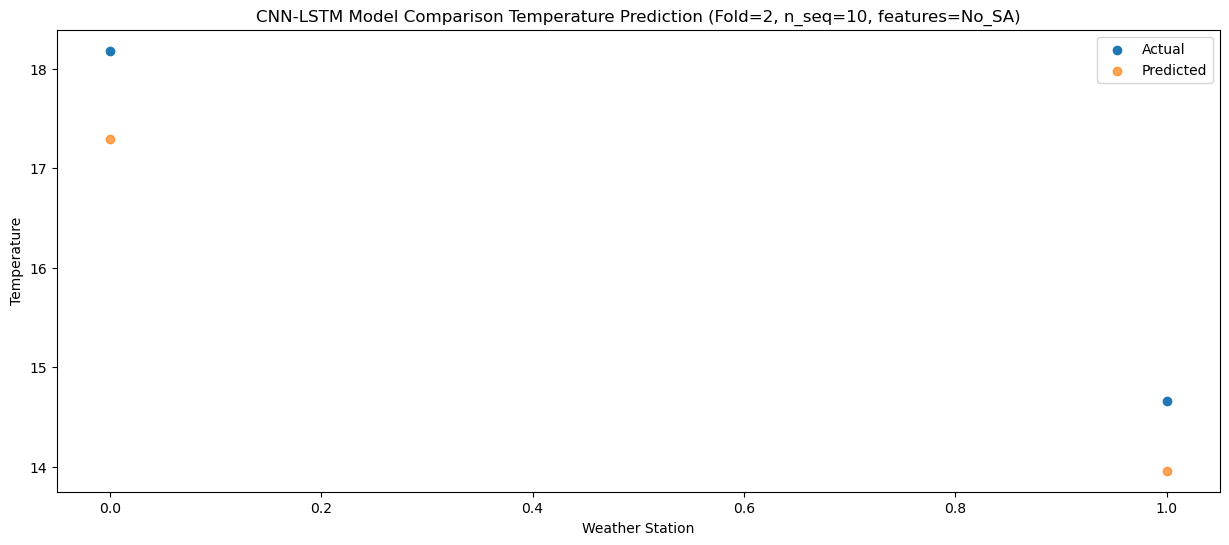

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   18.15  16.666515
1                1   14.20  13.336515


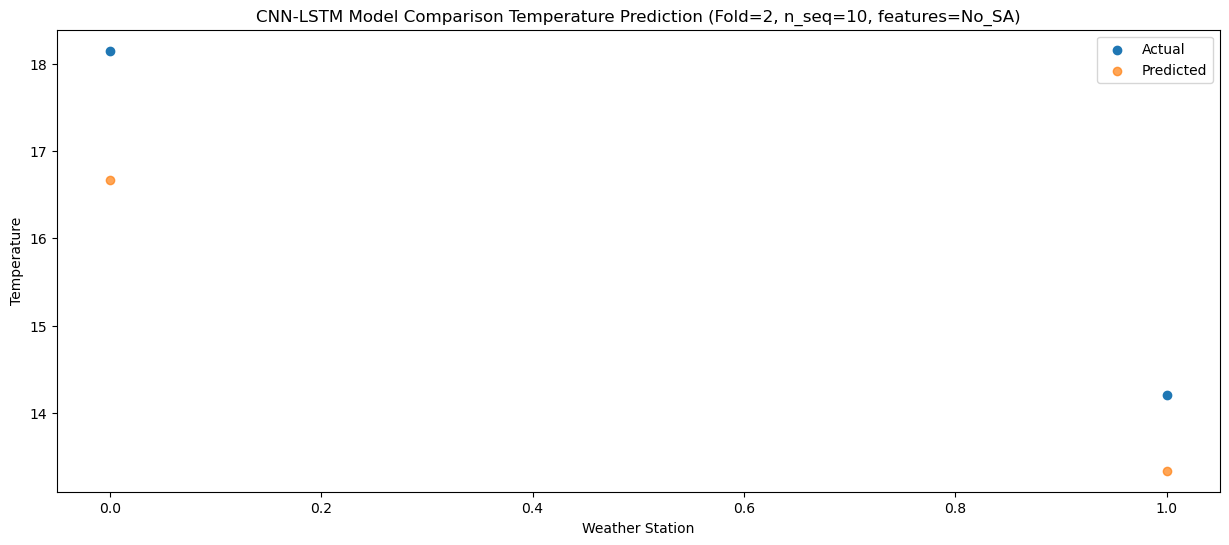

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   18.59  17.480327
1                1   14.99  14.150327


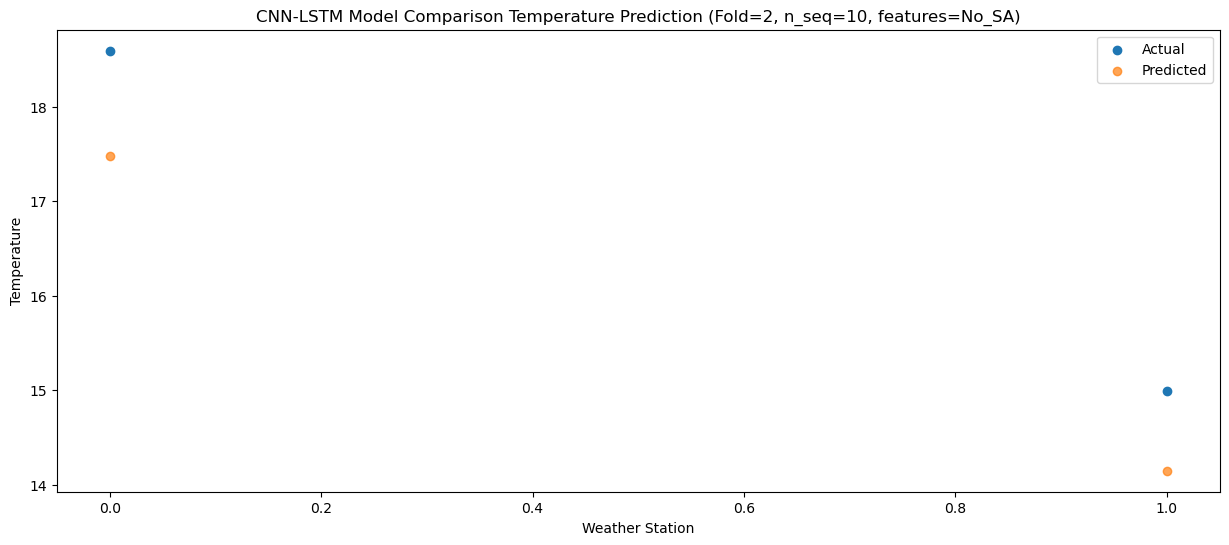

f, t:
[[16.98 12.89]
 [18.17 14.23]
 [18.73 15.  ]
 [18.51 14.82]
 [17.88 14.35]
 [18.64 14.68]
 [17.94 14.67]
 [18.18 14.66]
 [18.15 14.2 ]
 [18.59 14.99]]
[[16.41064375 13.08064375]
 [17.42033654 14.09033654]
 [17.99216771 14.66216771]
 [17.47966027 14.14966027]
 [16.74894499 13.41894499]
 [16.54255882 13.21255882]
 [17.21939197 13.88939197]
 [17.29189185 13.96189185]
 [16.66651503 13.33651503]
 [17.48032699 14.15032699]]
Year at t+1:
t+1 SKRMSE: 0.424565
t+1 KRMSE: 0.424565
t+1 MAE: 0.380000
t+1 SKMAPE: 0.024161
t+1 R2_SCORE: 0.956897
t+1 KMAPE: 0.024161
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.539213
t+2 KRMSE: 0.539213
t+2 MAE: 0.444663
t+2 SKMAPE: 0.025537
t+2 R2_SCORE: 0.925082
t+2 KMAPE: 0.025537
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.573815
t+3 KRMSE: 0.573815
t+3 MAE: 0.537832
t+3 SKMAPE: 0.030958
t+3 R2_SCORE: 0.905336
t+3 KMAPE: 0.030958
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.869182
t+4 KRMSE: 0.869182
t+4 MAE: 0.850340
t+4 SKMAPE: 0.050448
t+4 R

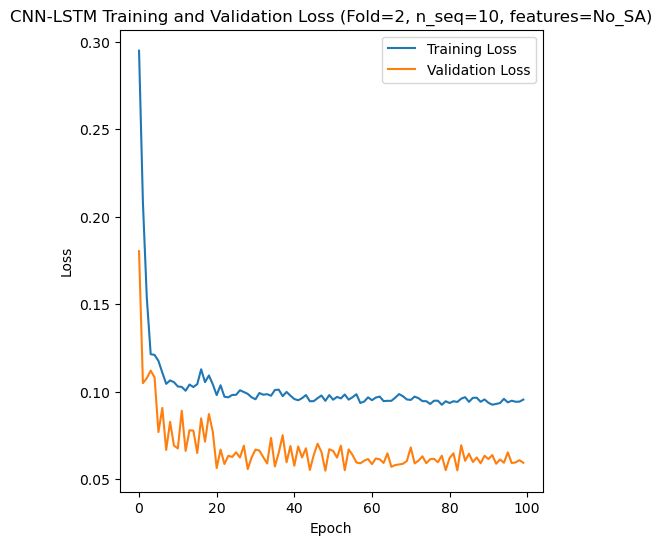

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 33s 668ms/step - loss: 0.3584 - accuracy: 0.1000 - mae: 0.3241 - rmse: 0.3584 - mape: 50.5195 - pearson: 0.2148 - val_loss: 0.3227 - val_accuracy: 0.0000e+00 - val_mae: 0.2693 - val_rmse: 0.3227 - val_mape: 39.2091 - val_pearson: 0.1896
Epoch 2/100
20/20 [==============================] - 3s 174ms/step - loss: 0.2119 - accuracy: 0.2000 - mae: 0.1791 - rmse: 0.2119 - mape: 27.5935 - pearson: 0.1880 - val_loss: 0.1179 - val_accuracy: 0.0000e+00 - val_mae: 0.0959 - val_rmse: 0.1179 - val_mape: 16.4728 - val_pearson: 0.6758
Epoch 3/100
20/20 [==============================] - 3s 162ms/step - loss: 0.1677 - 

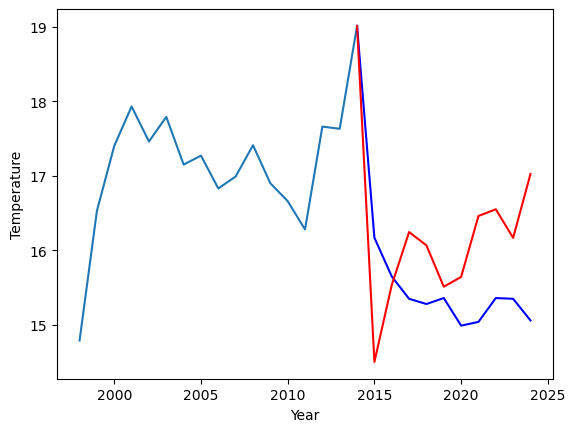

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.03		13.77		0.74
14.13		14.80		0.67
15.42		15.52		0.10
15.25		15.34		0.09
14.76		14.78		0.02
15.17		14.91		-0.26
15.05		15.73		0.68
14.85		15.82		0.97
14.55		15.44		0.89
15.57		16.29		0.72


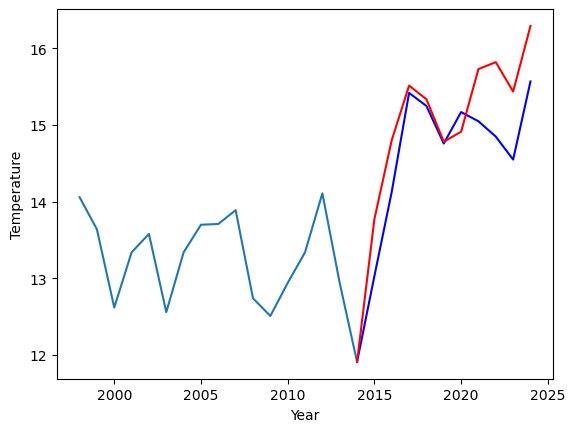

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.17  14.503312
1                1   13.03  13.773578


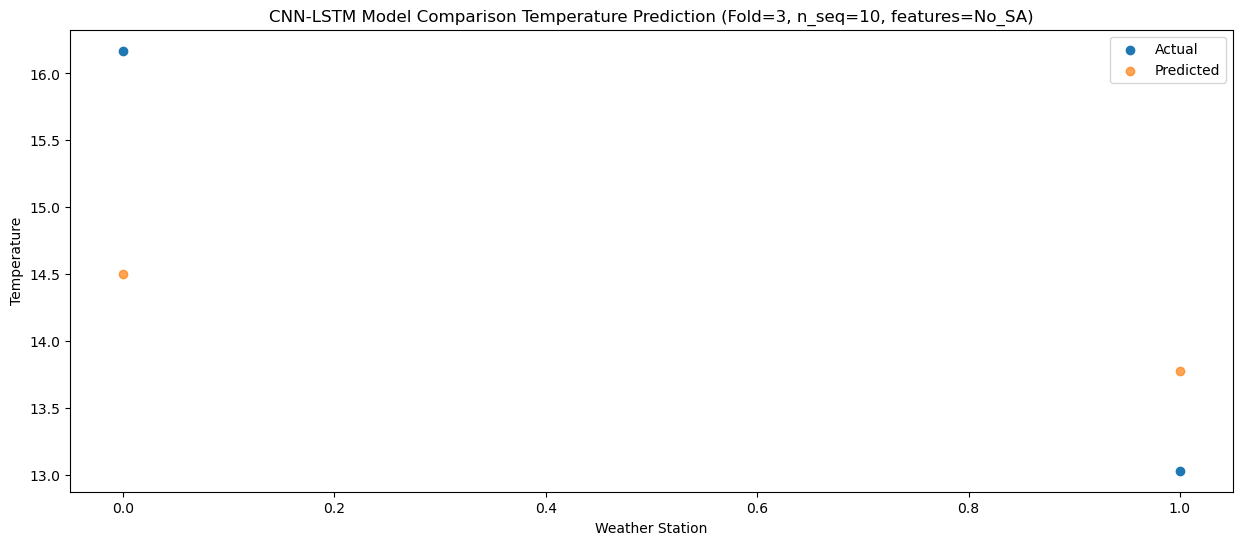

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   15.65  15.534024
1                1   14.13  14.803745


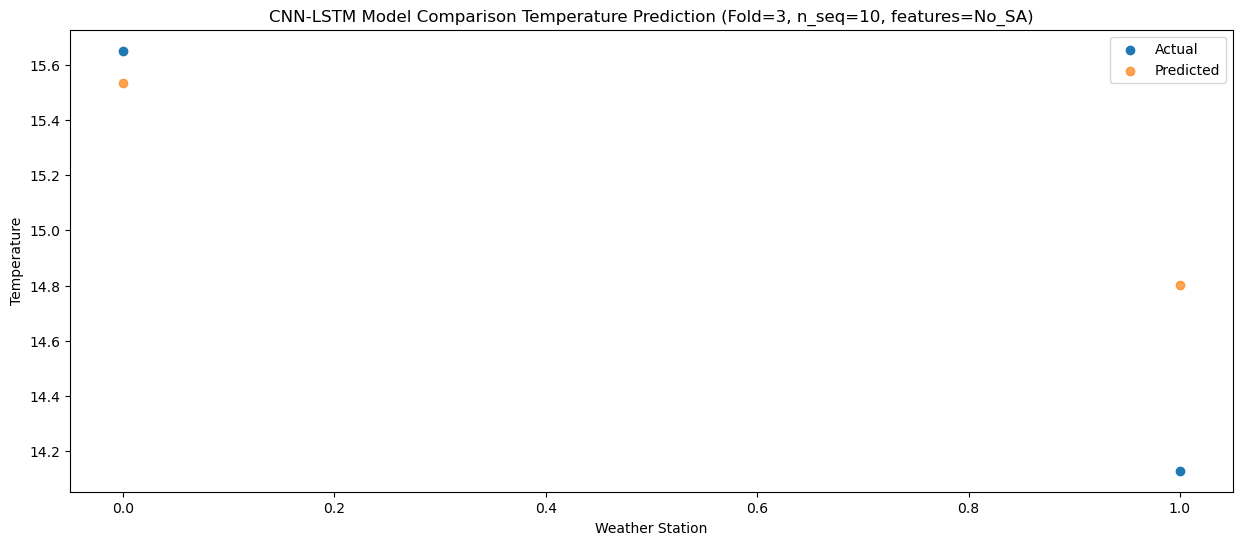

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   15.35  16.245341
1                1   15.42  15.515781


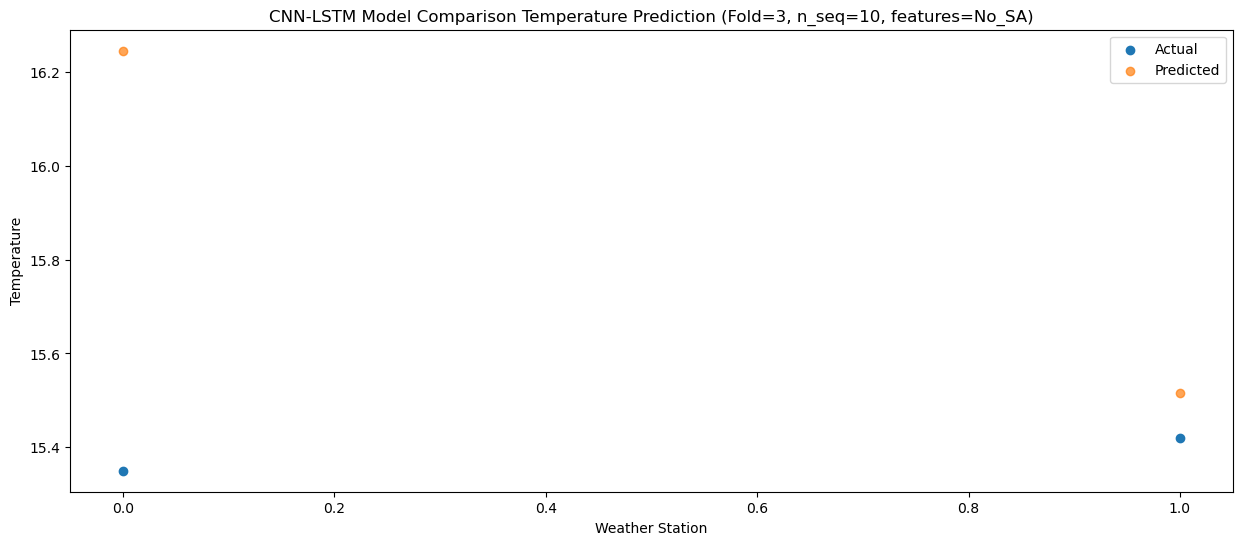

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   15.28  16.066867
1                1   15.25  15.337495


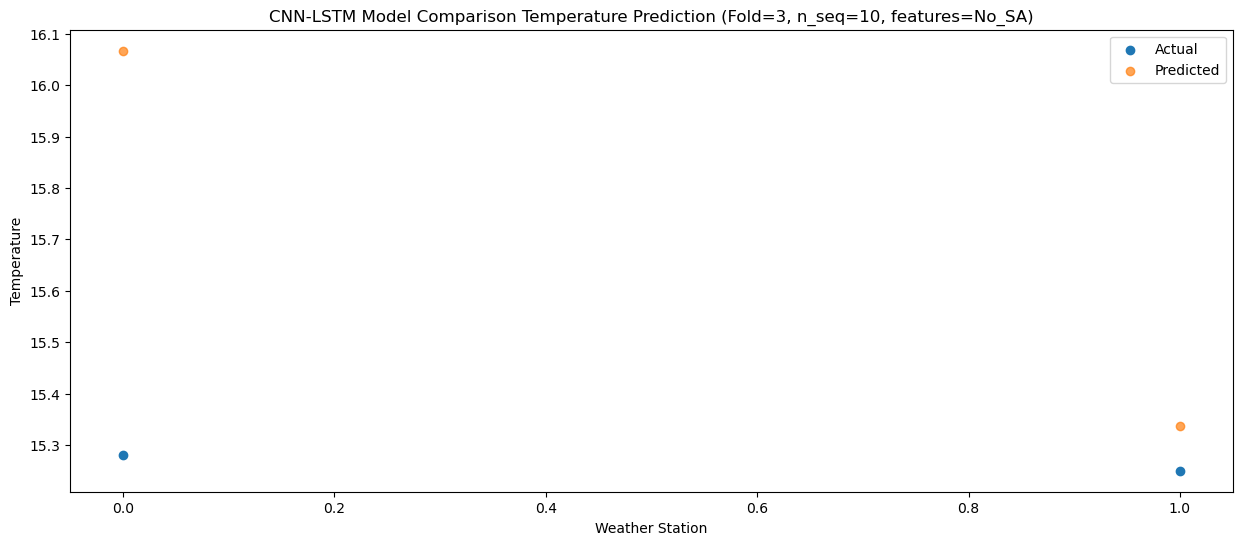

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   15.36  15.512531
1                1   14.76  14.783237


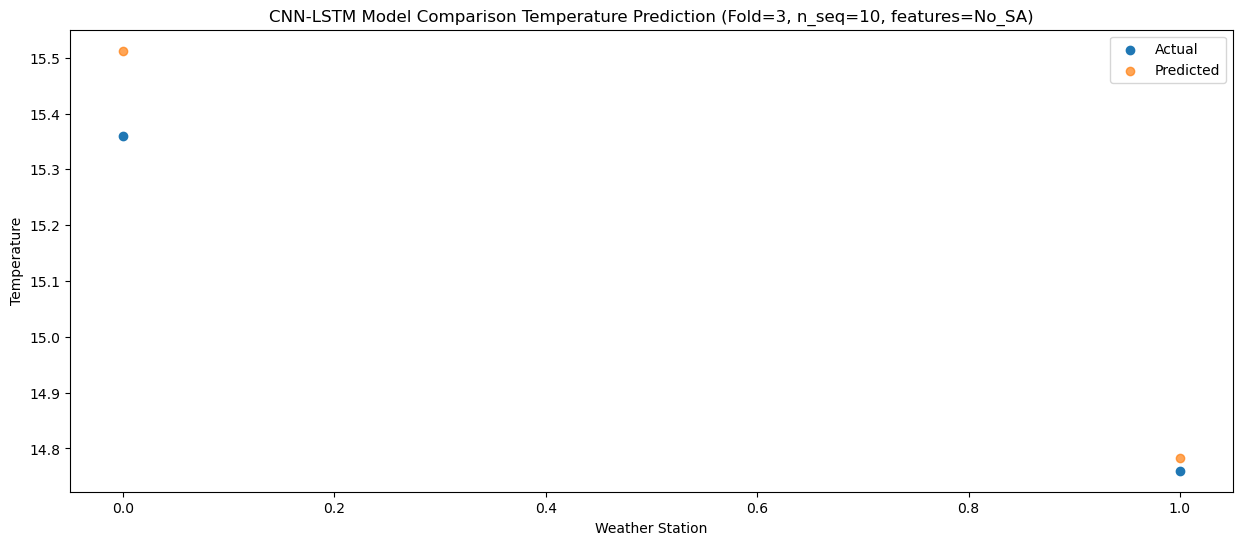

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   14.99  15.642849
1                1   15.17  14.913449


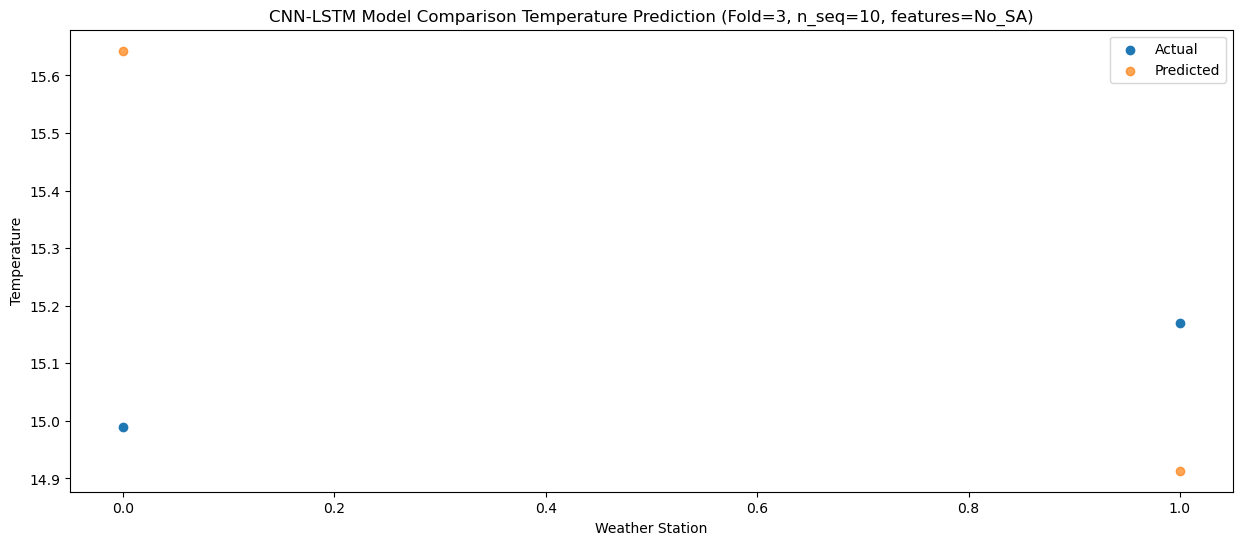

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   15.04  16.460749
1                1   15.05  15.731304


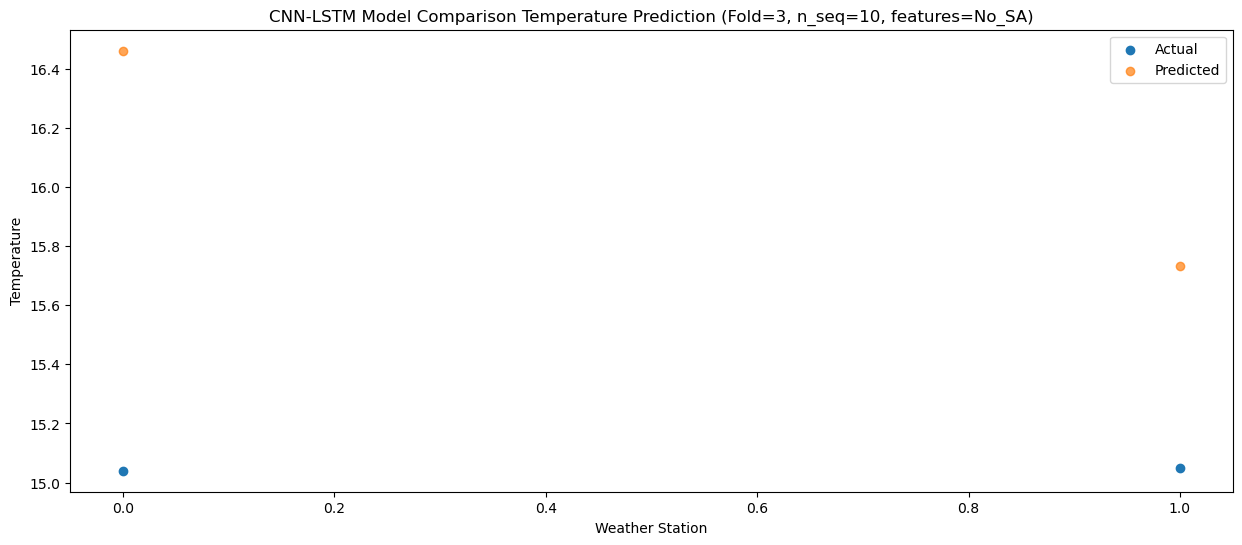

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   15.36  16.550780
1                1   14.85  15.821442


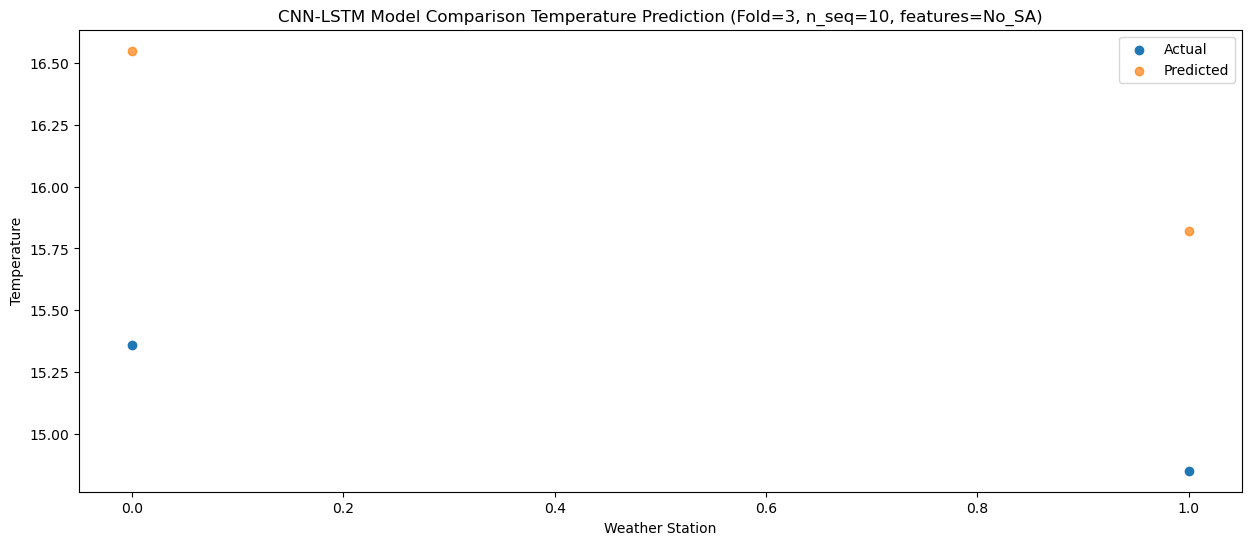

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   15.35  16.167229
1                1   14.55  15.437561


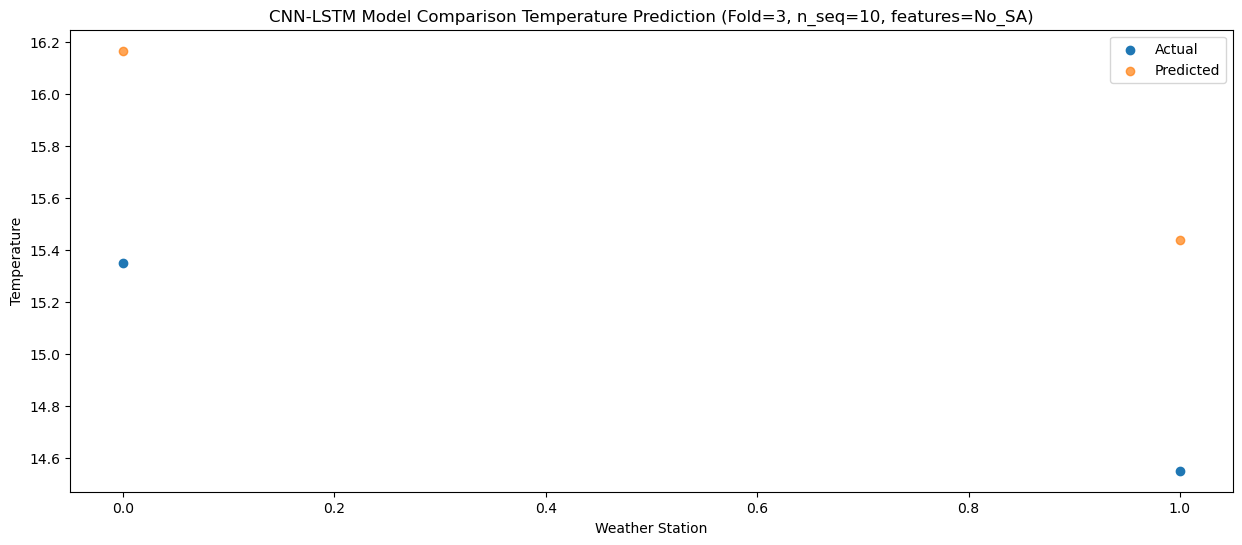

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   15.06  17.024575
1                1   15.57  16.294067


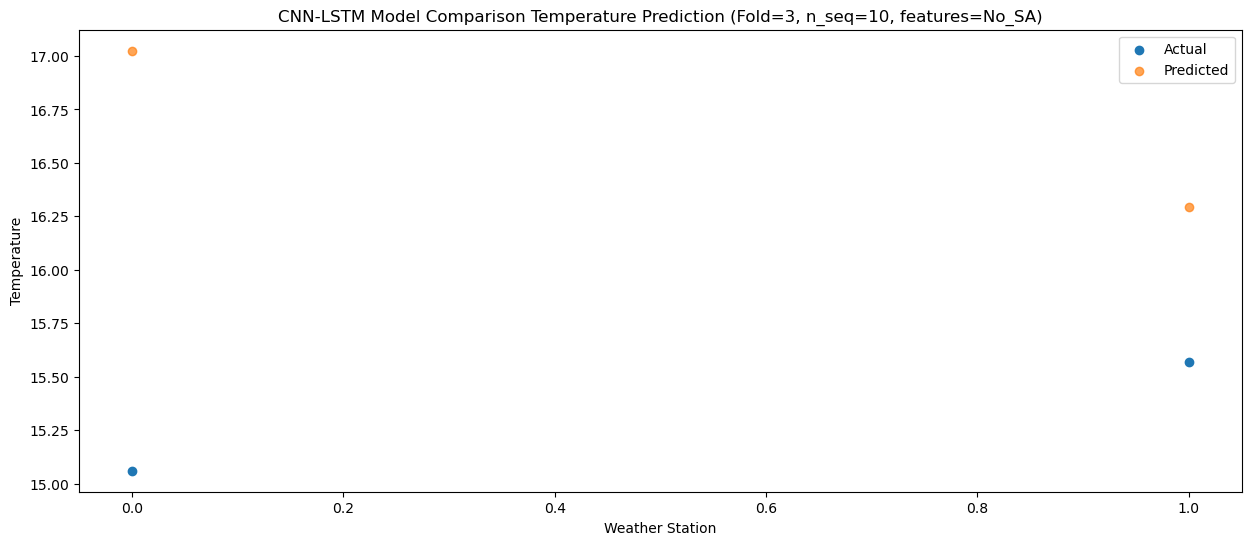

f, t:
[[16.17 13.03]
 [15.65 14.13]
 [15.35 15.42]
 [15.28 15.25]
 [15.36 14.76]
 [14.99 15.17]
 [15.04 15.05]
 [15.36 14.85]
 [15.35 14.55]
 [15.06 15.57]]
[[14.50331167 13.77357796]
 [15.53402416 14.8037453 ]
 [16.24534146 15.51578077]
 [16.06686685 15.33749464]
 [15.51253144 14.78323659]
 [15.64284874 14.91344851]
 [16.4607488  15.73130399]
 [16.55078015 15.82144193]
 [16.16722882 15.43756069]
 [17.02457458 16.29406745]]
Year at t+1:
t+1 SKRMSE: 1.290496
t+1 KRMSE: 1.290496
t+1 MAE: 1.205133
t+1 SKMAPE: 0.080070
t+1 R2_SCORE: 0.324362
t+1 KMAPE: 0.080070
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.483417
t+2 KRMSE: 0.483417
t+2 MAE: 0.394861
t+2 SKMAPE: 0.027546
t+2 R2_SCORE: 0.595409
t+2 KMAPE: 0.027546
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.636714
t+3 KRMSE: 0.636714
t+3 MAE: 0.495561
t+3 SKMAPE: 0.032270
t+3 R2_SCORE: -329.942973
t+3 KMAPE: 0.032270
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.559828
t+4 KRMSE: 0.559828
t+4 MAE: 0.437181
t+4 SKMAPE: 0.028617
t+

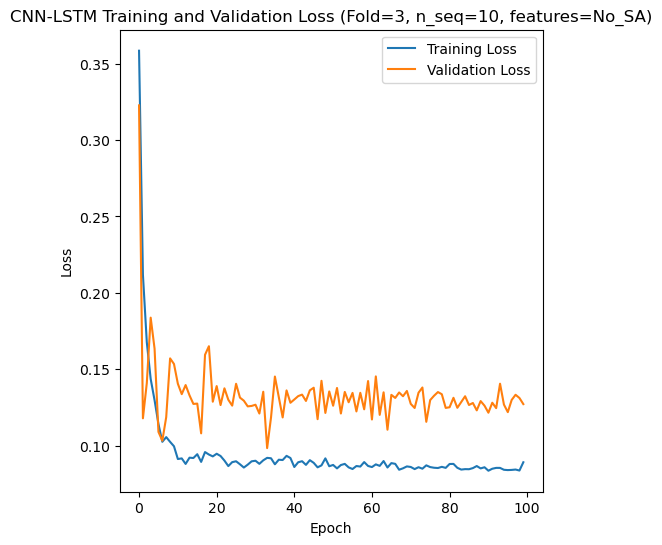

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 32s 477ms/step - loss: 0.2690 - accuracy: 0.2632 - mae: 0.2333 - rmse: 0.2690 - mape: 36.5812 - pearson: 0.2234 - val_loss: 0.2277 - val_accuracy: 0.0000e+00 - val_mae: 0.1817 - val_rmse: 0.2277 - val_mape: 35.4064 - val_pearson: 0.1143
Epoch 2/100
19/19 [==============================] - 2s 118ms/step - loss: 0.1750 - accuracy: 0.3158 - mae: 0.1479 - rmse: 0.1750 - mape: 24.2635 - pearson: 0.2364 - val_loss: 0.1488 - val_accuracy: 0.0000e+00 - val_mae: 0.1170 - val_rmse: 0.1488 - val_mape: 19.4427 - val_pearson: 0.2432
Epoch 3/100
19/19 [==============================] - 3s 147ms/step - loss: 0.1618 

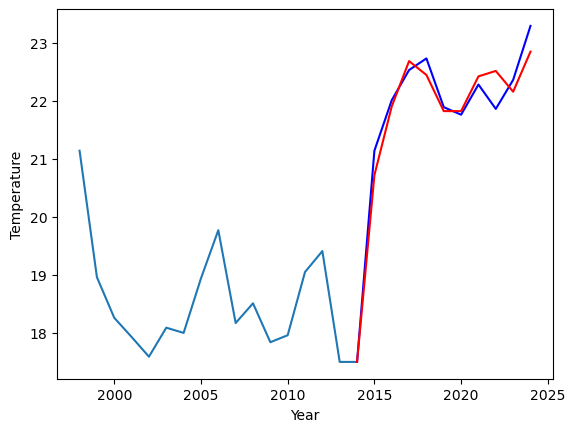

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.63		12.51		-0.12
14.58		13.69		-0.89
15.60		14.47		-1.13
15.53		14.24		-1.29
14.23		13.61		-0.62
13.53		13.61		0.08
14.09		14.21		0.12
14.41		14.31		-0.10
13.54		13.95		0.41
15.02		14.64		-0.38


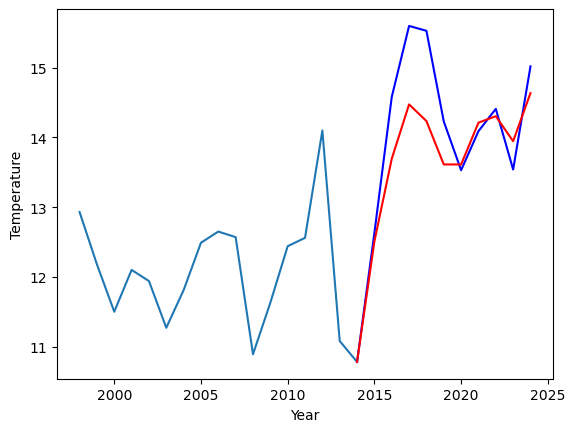

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.14  20.718535
1                1   12.63  12.508832


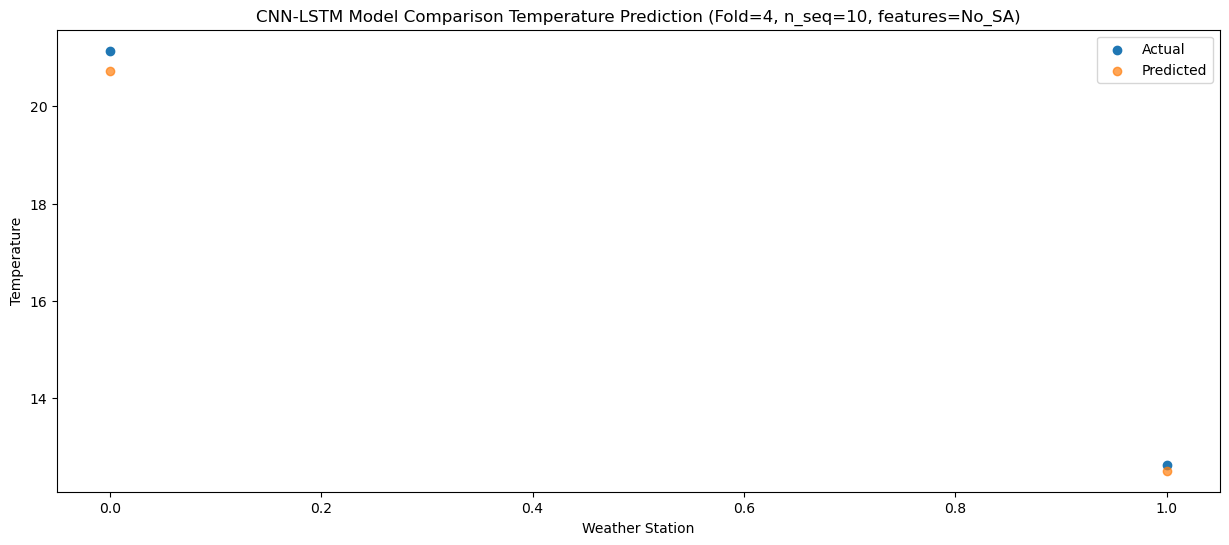

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   22.01  21.903162
1                1   14.58  13.693414


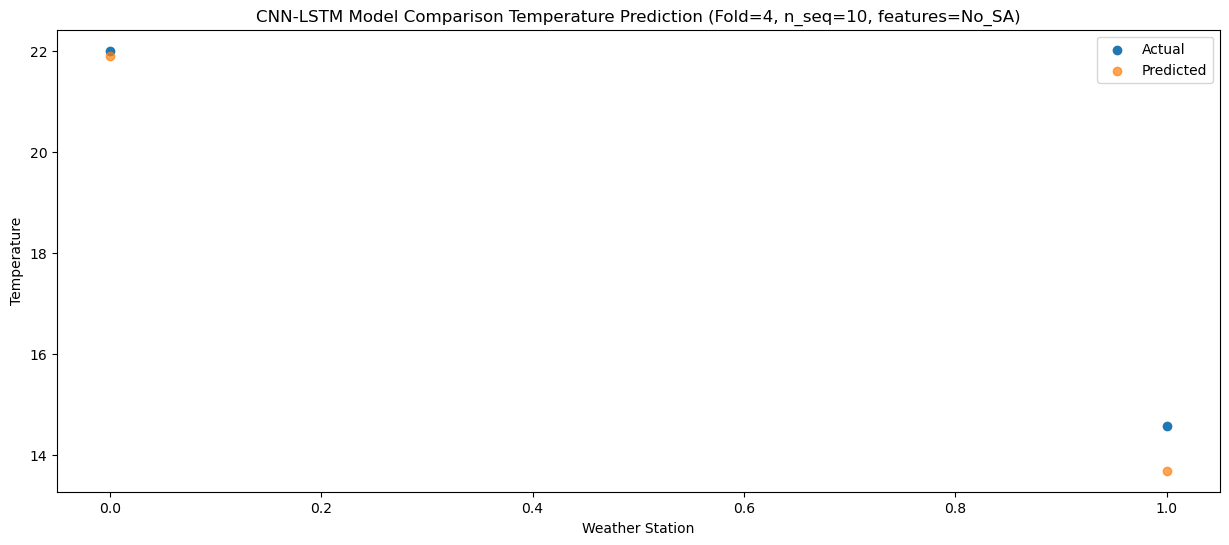

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.53  22.683802
1                1   15.60  14.474340


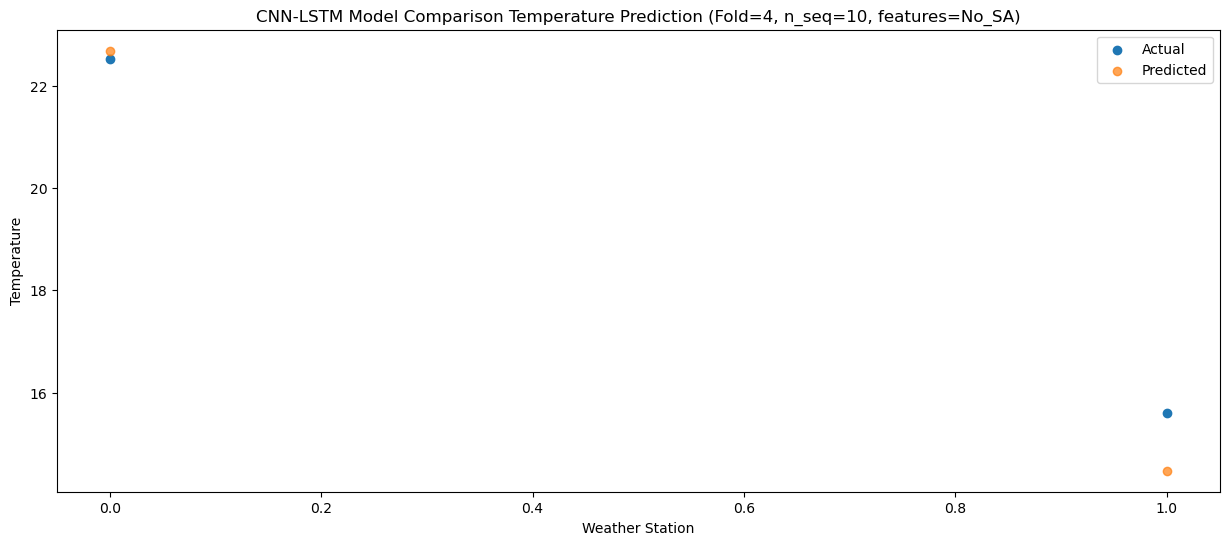

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.73  22.444717
1                1   15.53  14.235271


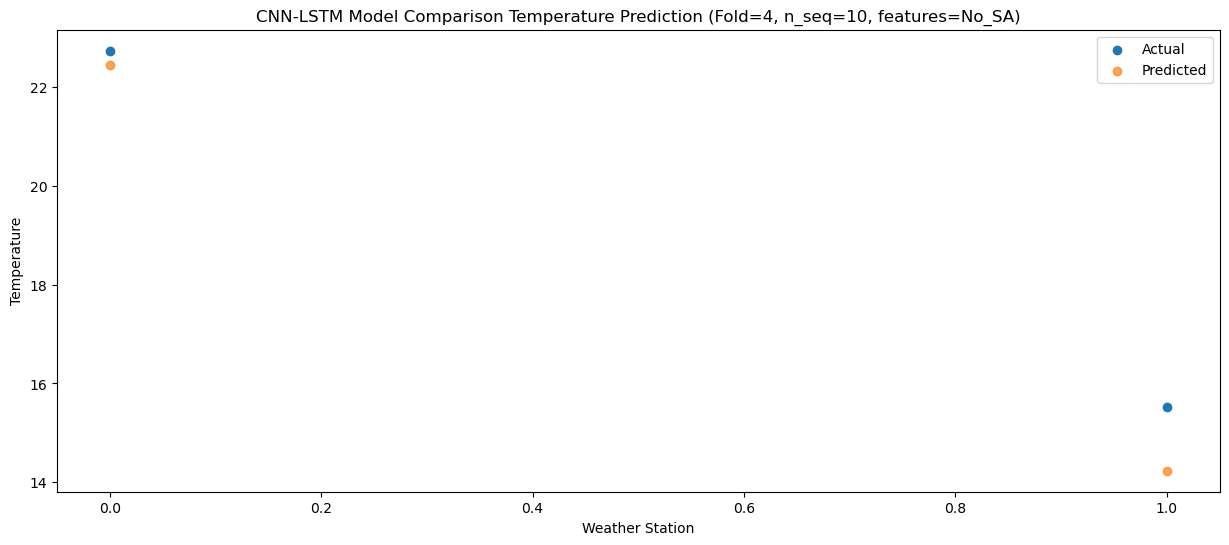

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.89  21.822099
1                1   14.23  13.612818


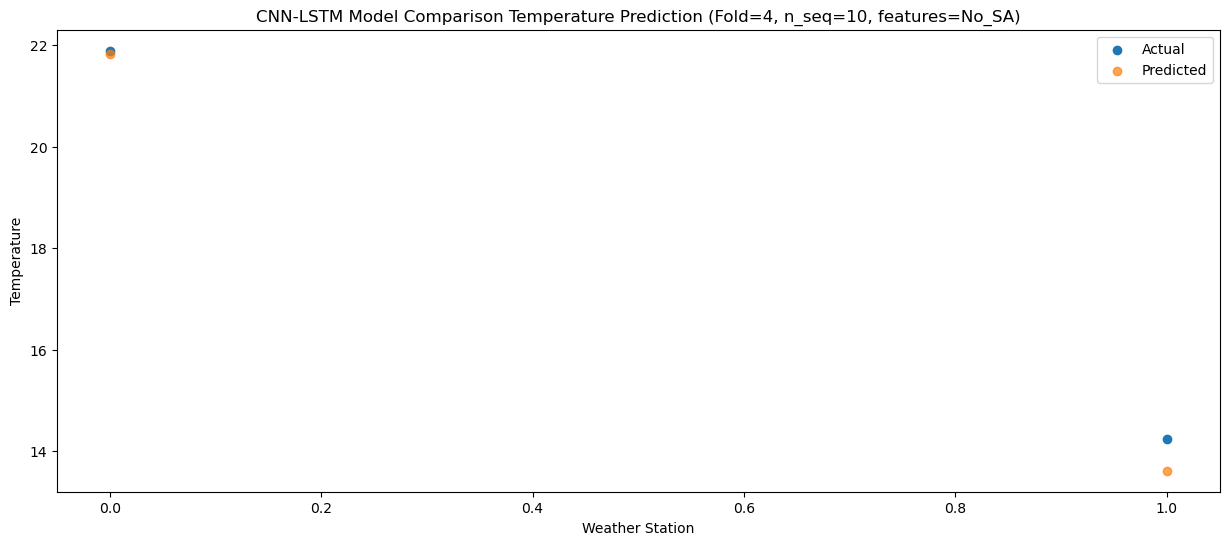

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.76  21.821533
1                1   13.53  13.612699


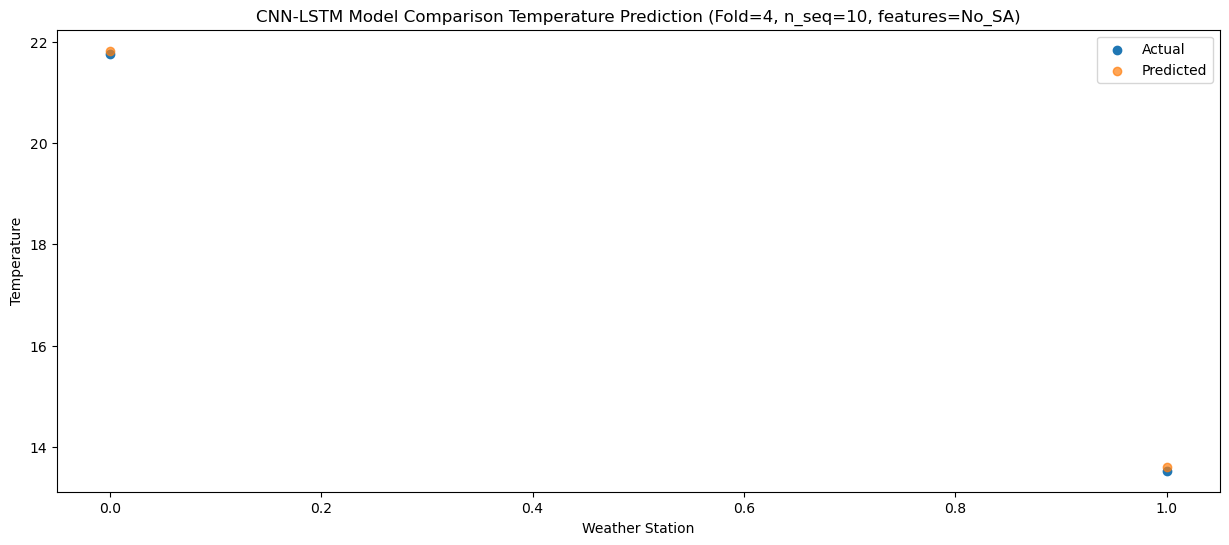

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   22.28  22.420578
1                1   14.09  14.211971


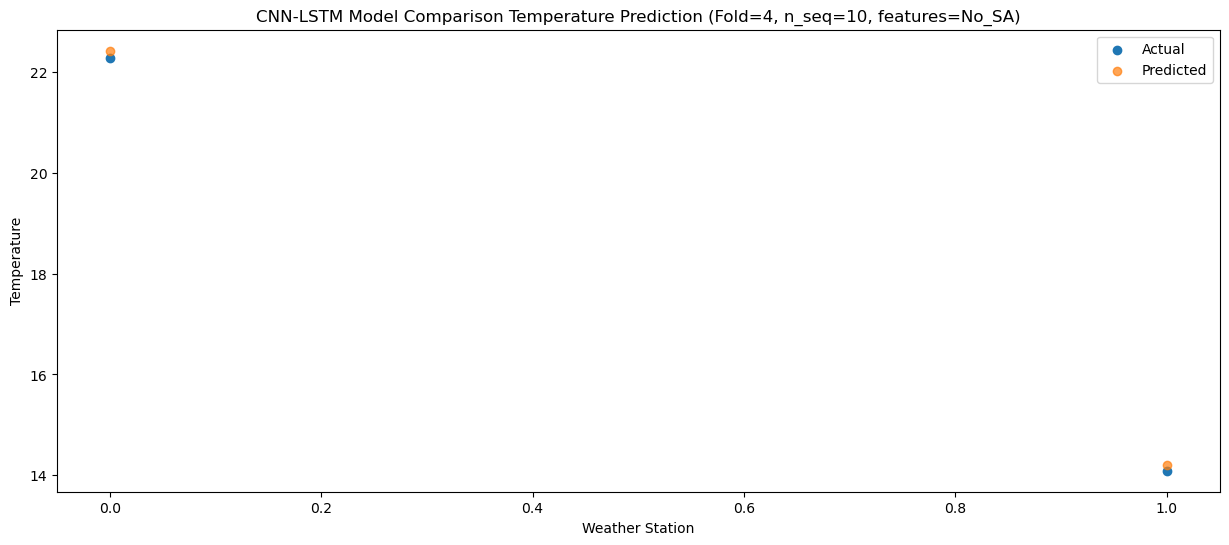

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.86  22.514193
1                1   14.41  14.305078


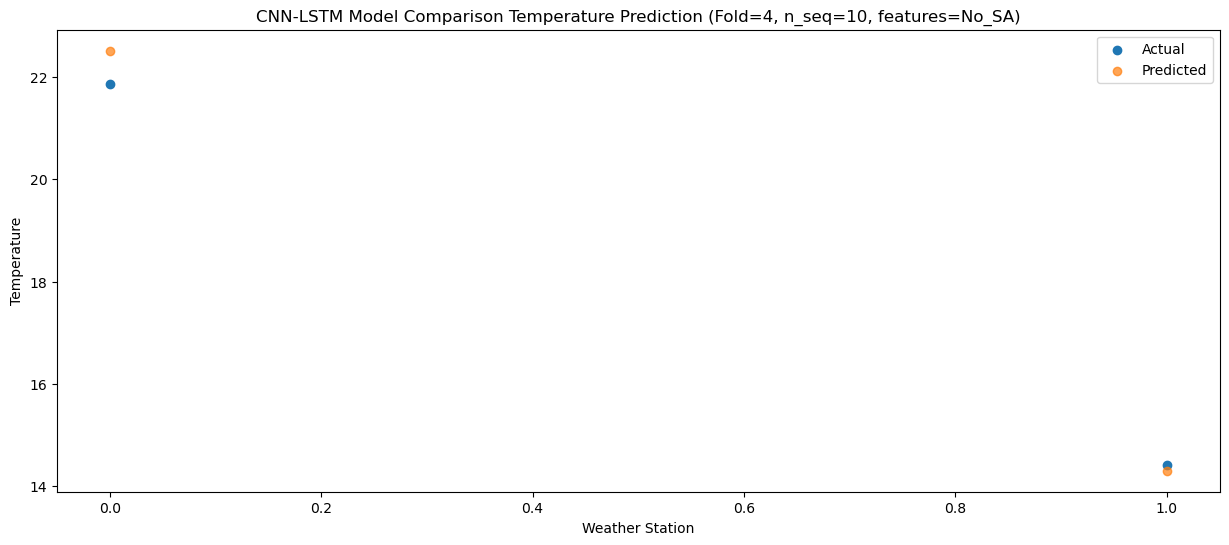

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   22.36  22.156209
1                1   13.54  13.946039


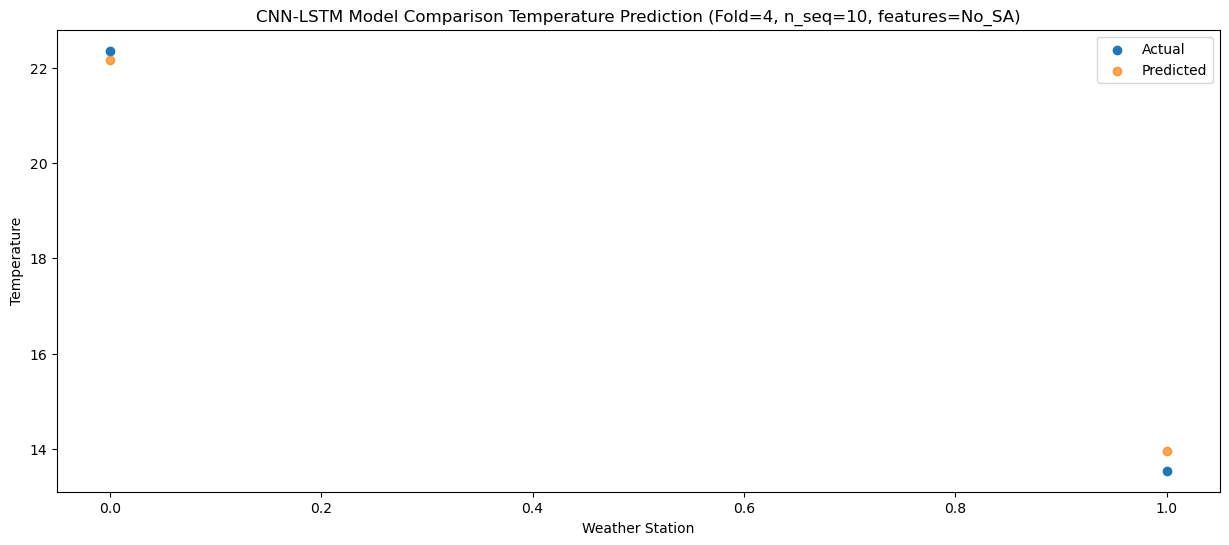

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   23.29  22.846413
1                1   15.02  14.636454


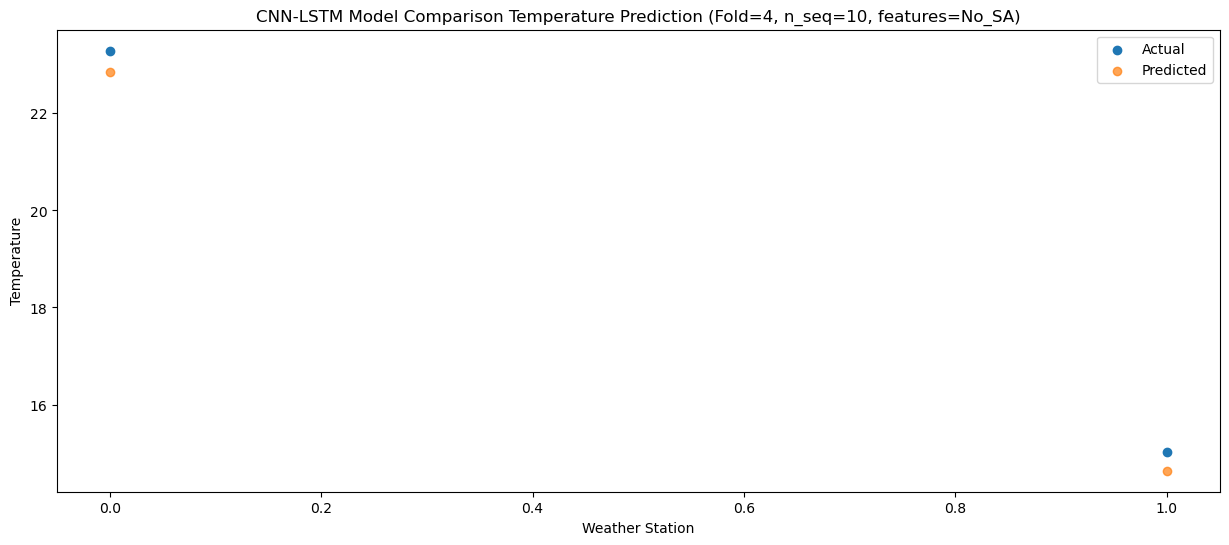

f, t:
[[21.14 12.63]
 [22.01 14.58]
 [22.53 15.6 ]
 [22.73 15.53]
 [21.89 14.23]
 [21.76 13.53]
 [22.28 14.09]
 [21.86 14.41]
 [22.36 13.54]
 [23.29 15.02]]
[[20.71853466 12.50883173]
 [21.90316196 13.69341444]
 [22.68380155 14.47433978]
 [22.44471672 14.2352709 ]
 [21.8220993  13.61281798]
 [21.82153343 13.61269942]
 [22.42057757 14.2119706 ]
 [22.51419299 14.30507828]
 [22.15620851 13.9460393 ]
 [22.84641271 14.63645414]]
Year at t+1:
t+1 SKRMSE: 0.310093
t+1 KRMSE: 0.310093
t+1 MAE: 0.271317
t+1 SKMAPE: 0.014765
t+1 R2_SCORE: 0.994689
t+1 KMAPE: 0.014765
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.631446
t+2 KRMSE: 0.631446
t+2 MAE: 0.496712
t+2 SKMAPE: 0.032831
t+2 R2_SCORE: 0.971110
t+2 KMAPE: 0.032831
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.803357
t+3 KRMSE: 0.803357
t+3 MAE: 0.639731
t+3 SKMAPE: 0.039492
t+3 R2_SCORE: 0.946246
t+3 KMAPE: 0.039492
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.937473
t+4 KRMSE: 0.937473
t+4 MAE: 0.790006
t+4 SKMAPE: 0.047960
t+4 R

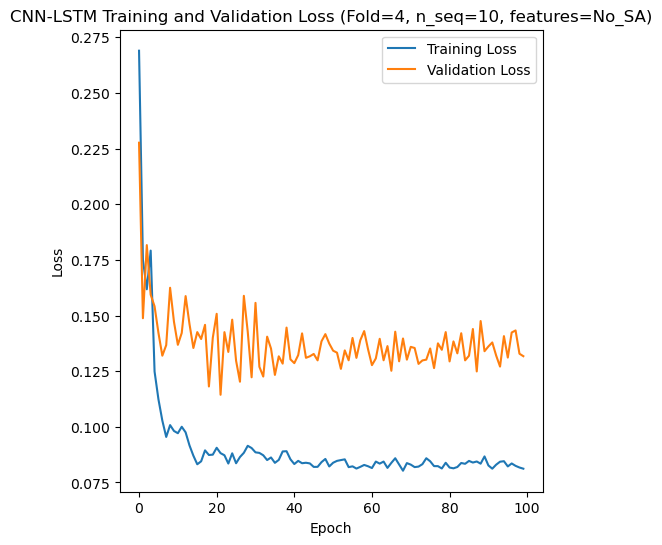

[[0.5346196998451187], [0.46071743660140296], [0.9771837596399917], [0.9065157246257299], [0.5224117423832558]]
[[array(0.5346197)], [array(0.46071744)], [array(0.97718376)], [array(0.90651572)], [array(0.52241174)]]
[[0.3884910904988644], [0.36891686609387425], [0.8718205824494367], [0.7404172907322641], [0.38417368725049883]]
[[0.020092250521565862], [0.018319419222246572], [0.0525465771687482], [0.04914222722436979], [0.023068478502635353]]
[[0.9321523120361471], [0.056854487822730504], [0.7463790772736332], [-1.107565202377475], [0.9829745880978427]]
[[array(0.02009225)], [array(0.01831942)], [array(0.05254658)], [array(0.04914223)], [array(0.02306848)]]
[[array(0.95069371)], [array(0.30819172)], [array(0.94578152)], [array(0.21026624)], [array(0.98778231)]]
[20.39 21.69 22.42 22.78 21.56 21.49 21.66 21.49 21.73 22.15 16.37 17.64
 17.8  18.04 18.   18.95 18.12 17.61 17.89 17.72 19.63 20.16 20.45 20.41
 20.24 20.32 20.41 19.49 19.83 20.67 19.88 19.4  20.43 20.81 19.96 20.09
 20.61 2

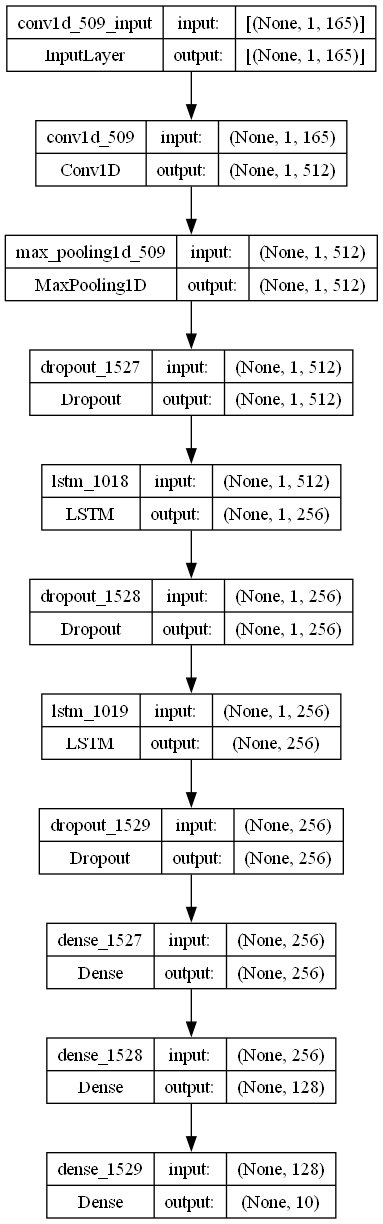

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.0025481898960211524
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 256
    dropout_rate = 0.27879037015196534

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S10_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)